# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

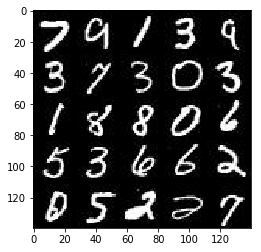

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

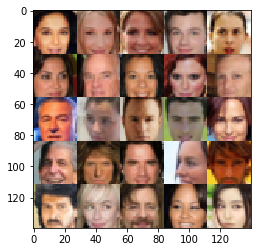

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    data= tf.placeholder(tf.float32, (None, z_dim))
    learning_rate = tf.placeholder(tf.float32)
    return inputs, data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse=reuse):
        # image 28*28*3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        relu1 = tf.nn.dropout(relu1, 0.8)
        # 14*14*64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        relu2 = tf.nn.dropout(relu2, 0.8)
        # 7*7*128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        relu3 = tf.nn.dropout(relu3, 0.8)
        
        x4 = tf.layers.conv2d(relu3, 512, 5, strides=2, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        relu4 = tf.nn.dropout(relu4, 0.8)
        
#         flatten = tf.reshape(relu4, (-1, 4 * 4 * 256))
        flatten = tf.contrib.layers.flatten(relu4)
        logits = tf.layers.dense(flatten, 1)
        output = tf.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [20]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    # TODO: Implement Function
    with tf.variable_scope("generator", reuse = not is_train):
        x1 = tf.layers.dense(z, 2*2*512)
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, 0.5)
        #4x4x512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, 0.5)
        #8x8x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, 0.5)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        
        output = tf.tanh(logits)
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [21]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
                                 
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [22]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [23]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [24]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    image_width = data_shape[1]
    image_height = data_shape[2]
    channel = data_shape[3]
    steps = 0
    print_every = 10
    show_every = 100
    
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, channel, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channel)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2

                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(d_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, learn_rate: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, learn_rate: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, learn_rate: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{} Batch Step {}...".format(epoch_i, epoch_count, steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 10, input_z, channel, data_image_mode)
                
        print('Done Training!')
        show_generator_output(sess, 20, input_z, channel, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2 Batch Step 10... Discriminator Loss: 2.0021... Generator Loss: 5.0126
Epoch 0/2 Batch Step 20... Discriminator Loss: 2.6830... Generator Loss: 0.2635
Epoch 0/2 Batch Step 30... Discriminator Loss: 1.0340... Generator Loss: 1.3029
Epoch 0/2 Batch Step 40... Discriminator Loss: 2.2395... Generator Loss: 0.7258
Epoch 0/2 Batch Step 50... Discriminator Loss: 1.5091... Generator Loss: 1.2305
Epoch 0/2 Batch Step 60... Discriminator Loss: 0.8998... Generator Loss: 1.7370
Epoch 0/2 Batch Step 70... Discriminator Loss: 1.0297... Generator Loss: 2.0601
Epoch 0/2 Batch Step 80... Discriminator Loss: 1.5234... Generator Loss: 0.5303
Epoch 0/2 Batch Step 90... Discriminator Loss: 2.2485... Generator Loss: 0.8348
Epoch 0/2 Batch Step 100... Discriminator Loss: 1.1836... Generator Loss: 1.2147


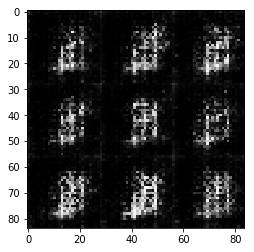

Epoch 0/2 Batch Step 110... Discriminator Loss: 0.7524... Generator Loss: 1.9354
Epoch 0/2 Batch Step 120... Discriminator Loss: 0.9174... Generator Loss: 0.9896
Epoch 0/2 Batch Step 130... Discriminator Loss: 0.7984... Generator Loss: 2.0597
Epoch 0/2 Batch Step 140... Discriminator Loss: 1.5952... Generator Loss: 0.7376
Epoch 0/2 Batch Step 150... Discriminator Loss: 0.8737... Generator Loss: 1.3204
Epoch 0/2 Batch Step 160... Discriminator Loss: 1.1803... Generator Loss: 1.2703
Epoch 0/2 Batch Step 170... Discriminator Loss: 0.6386... Generator Loss: 2.3774
Epoch 0/2 Batch Step 180... Discriminator Loss: 0.5136... Generator Loss: 2.7965
Epoch 0/2 Batch Step 190... Discriminator Loss: 0.4748... Generator Loss: 2.6487
Epoch 0/2 Batch Step 200... Discriminator Loss: 0.4884... Generator Loss: 4.3670


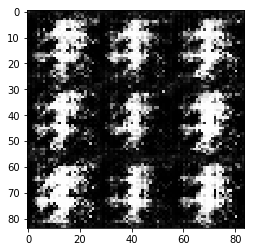

Epoch 0/2 Batch Step 210... Discriminator Loss: 0.5572... Generator Loss: 1.8380
Epoch 0/2 Batch Step 220... Discriminator Loss: 0.7875... Generator Loss: 1.1861
Epoch 0/2 Batch Step 230... Discriminator Loss: 0.9754... Generator Loss: 3.8535
Epoch 0/2 Batch Step 240... Discriminator Loss: 0.9143... Generator Loss: 1.2106
Epoch 0/2 Batch Step 250... Discriminator Loss: 1.2293... Generator Loss: 1.0866
Epoch 0/2 Batch Step 260... Discriminator Loss: 1.2208... Generator Loss: 1.6315
Epoch 0/2 Batch Step 270... Discriminator Loss: 0.8611... Generator Loss: 1.6925
Epoch 0/2 Batch Step 280... Discriminator Loss: 0.9575... Generator Loss: 1.2147
Epoch 0/2 Batch Step 290... Discriminator Loss: 0.7775... Generator Loss: 2.7247
Epoch 0/2 Batch Step 300... Discriminator Loss: 0.8356... Generator Loss: 1.3551


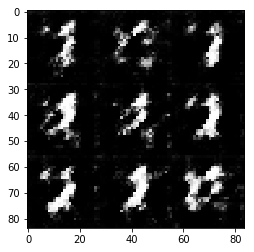

Epoch 0/2 Batch Step 310... Discriminator Loss: 0.7197... Generator Loss: 2.3672
Epoch 0/2 Batch Step 320... Discriminator Loss: 0.8758... Generator Loss: 1.8802
Epoch 0/2 Batch Step 330... Discriminator Loss: 1.1924... Generator Loss: 1.9799
Epoch 0/2 Batch Step 340... Discriminator Loss: 1.0219... Generator Loss: 1.4214
Epoch 0/2 Batch Step 350... Discriminator Loss: 1.1307... Generator Loss: 1.0730
Epoch 0/2 Batch Step 360... Discriminator Loss: 1.2765... Generator Loss: 1.5285
Epoch 0/2 Batch Step 370... Discriminator Loss: 1.0907... Generator Loss: 1.9440
Epoch 0/2 Batch Step 380... Discriminator Loss: 1.3102... Generator Loss: 0.7007
Epoch 0/2 Batch Step 390... Discriminator Loss: 0.9001... Generator Loss: 1.5997
Epoch 0/2 Batch Step 400... Discriminator Loss: 1.8082... Generator Loss: 0.3472


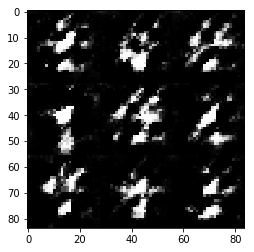

Epoch 0/2 Batch Step 410... Discriminator Loss: 1.2969... Generator Loss: 0.7920
Epoch 0/2 Batch Step 420... Discriminator Loss: 1.0255... Generator Loss: 1.2883
Epoch 0/2 Batch Step 430... Discriminator Loss: 1.0040... Generator Loss: 1.5234
Epoch 0/2 Batch Step 440... Discriminator Loss: 1.1709... Generator Loss: 1.9565
Epoch 0/2 Batch Step 450... Discriminator Loss: 1.1582... Generator Loss: 0.8299
Epoch 0/2 Batch Step 460... Discriminator Loss: 1.2669... Generator Loss: 0.8597
Epoch 0/2 Batch Step 470... Discriminator Loss: 0.7994... Generator Loss: 1.2147
Epoch 0/2 Batch Step 480... Discriminator Loss: 1.7448... Generator Loss: 0.3631
Epoch 0/2 Batch Step 490... Discriminator Loss: 1.1014... Generator Loss: 2.0849
Epoch 0/2 Batch Step 500... Discriminator Loss: 1.0172... Generator Loss: 1.0671


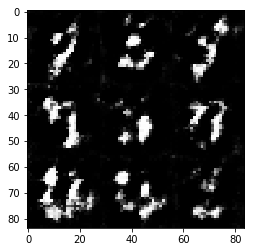

Epoch 0/2 Batch Step 510... Discriminator Loss: 1.3414... Generator Loss: 0.9721
Epoch 0/2 Batch Step 520... Discriminator Loss: 1.3140... Generator Loss: 1.3526
Epoch 0/2 Batch Step 530... Discriminator Loss: 0.9203... Generator Loss: 1.8007
Epoch 0/2 Batch Step 540... Discriminator Loss: 1.6488... Generator Loss: 1.0413
Epoch 0/2 Batch Step 550... Discriminator Loss: 1.0739... Generator Loss: 0.8940
Epoch 0/2 Batch Step 560... Discriminator Loss: 1.0797... Generator Loss: 1.5571
Epoch 0/2 Batch Step 570... Discriminator Loss: 1.3141... Generator Loss: 1.0420
Epoch 0/2 Batch Step 580... Discriminator Loss: 1.1405... Generator Loss: 1.1801
Epoch 0/2 Batch Step 590... Discriminator Loss: 1.0901... Generator Loss: 1.3544
Epoch 0/2 Batch Step 600... Discriminator Loss: 1.2081... Generator Loss: 1.0826


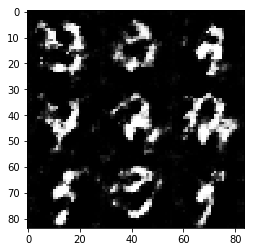

Epoch 0/2 Batch Step 610... Discriminator Loss: 0.6740... Generator Loss: 1.9564
Epoch 0/2 Batch Step 620... Discriminator Loss: 0.9792... Generator Loss: 1.0657
Epoch 0/2 Batch Step 630... Discriminator Loss: 1.2736... Generator Loss: 1.2081
Epoch 0/2 Batch Step 640... Discriminator Loss: 0.9305... Generator Loss: 2.0515
Epoch 0/2 Batch Step 650... Discriminator Loss: 1.3425... Generator Loss: 0.9483
Epoch 0/2 Batch Step 660... Discriminator Loss: 0.8671... Generator Loss: 1.2572
Epoch 0/2 Batch Step 670... Discriminator Loss: 0.7814... Generator Loss: 1.4724
Epoch 0/2 Batch Step 680... Discriminator Loss: 0.7488... Generator Loss: 0.9636
Epoch 0/2 Batch Step 690... Discriminator Loss: 1.1730... Generator Loss: 0.6648
Epoch 0/2 Batch Step 700... Discriminator Loss: 0.8460... Generator Loss: 1.4072


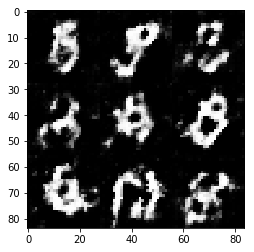

Epoch 0/2 Batch Step 710... Discriminator Loss: 1.1574... Generator Loss: 0.7591
Epoch 0/2 Batch Step 720... Discriminator Loss: 0.9388... Generator Loss: 1.5894
Epoch 0/2 Batch Step 730... Discriminator Loss: 1.1843... Generator Loss: 0.8281
Epoch 0/2 Batch Step 740... Discriminator Loss: 1.0644... Generator Loss: 1.1687
Epoch 0/2 Batch Step 750... Discriminator Loss: 1.0282... Generator Loss: 1.1892
Epoch 0/2 Batch Step 760... Discriminator Loss: 0.9301... Generator Loss: 1.0190
Epoch 0/2 Batch Step 770... Discriminator Loss: 0.8116... Generator Loss: 1.6898
Epoch 0/2 Batch Step 780... Discriminator Loss: 0.8618... Generator Loss: 1.9522
Epoch 0/2 Batch Step 790... Discriminator Loss: 1.1220... Generator Loss: 1.4469
Epoch 0/2 Batch Step 800... Discriminator Loss: 0.9983... Generator Loss: 1.5633


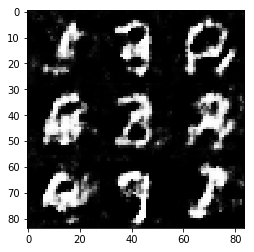

Epoch 0/2 Batch Step 810... Discriminator Loss: 0.7861... Generator Loss: 1.3779
Epoch 0/2 Batch Step 820... Discriminator Loss: 1.1231... Generator Loss: 1.2221
Epoch 0/2 Batch Step 830... Discriminator Loss: 0.8539... Generator Loss: 1.2985
Epoch 0/2 Batch Step 840... Discriminator Loss: 1.4312... Generator Loss: 1.4483
Epoch 0/2 Batch Step 850... Discriminator Loss: 0.8263... Generator Loss: 1.5372
Epoch 0/2 Batch Step 860... Discriminator Loss: 0.8144... Generator Loss: 1.2839
Epoch 0/2 Batch Step 870... Discriminator Loss: 1.1919... Generator Loss: 1.0986
Epoch 0/2 Batch Step 880... Discriminator Loss: 1.1031... Generator Loss: 1.9079
Epoch 0/2 Batch Step 890... Discriminator Loss: 1.0675... Generator Loss: 0.7181
Epoch 0/2 Batch Step 900... Discriminator Loss: 1.0179... Generator Loss: 0.9052


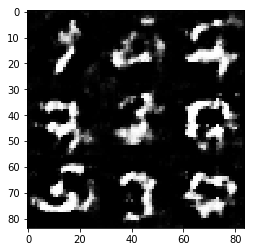

Epoch 0/2 Batch Step 910... Discriminator Loss: 0.8958... Generator Loss: 1.2637
Epoch 0/2 Batch Step 920... Discriminator Loss: 1.1235... Generator Loss: 0.9408
Epoch 0/2 Batch Step 930... Discriminator Loss: 0.6765... Generator Loss: 1.6654
Epoch 0/2 Batch Step 940... Discriminator Loss: 0.9898... Generator Loss: 1.3639
Epoch 0/2 Batch Step 950... Discriminator Loss: 0.9331... Generator Loss: 1.0798
Epoch 0/2 Batch Step 960... Discriminator Loss: 1.1550... Generator Loss: 0.9800
Epoch 0/2 Batch Step 970... Discriminator Loss: 1.0125... Generator Loss: 0.6957
Epoch 0/2 Batch Step 980... Discriminator Loss: 1.0549... Generator Loss: 2.5948
Epoch 0/2 Batch Step 990... Discriminator Loss: 0.7281... Generator Loss: 1.7623
Epoch 0/2 Batch Step 1000... Discriminator Loss: 1.1938... Generator Loss: 0.4661


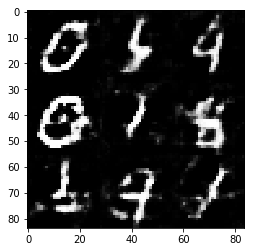

Epoch 0/2 Batch Step 1010... Discriminator Loss: 0.7655... Generator Loss: 1.8180
Epoch 0/2 Batch Step 1020... Discriminator Loss: 0.8854... Generator Loss: 1.2796
Epoch 0/2 Batch Step 1030... Discriminator Loss: 0.7538... Generator Loss: 2.8618
Epoch 0/2 Batch Step 1040... Discriminator Loss: 0.6895... Generator Loss: 1.3099
Epoch 0/2 Batch Step 1050... Discriminator Loss: 1.1467... Generator Loss: 2.9822
Epoch 0/2 Batch Step 1060... Discriminator Loss: 0.8891... Generator Loss: 1.6202
Epoch 0/2 Batch Step 1070... Discriminator Loss: 0.8011... Generator Loss: 2.2491
Epoch 0/2 Batch Step 1080... Discriminator Loss: 0.6799... Generator Loss: 1.0965
Epoch 0/2 Batch Step 1090... Discriminator Loss: 1.2872... Generator Loss: 0.8590
Epoch 0/2 Batch Step 1100... Discriminator Loss: 0.7171... Generator Loss: 1.0204


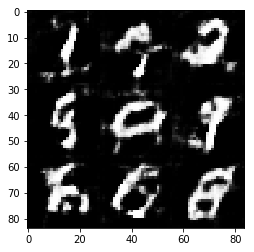

Epoch 0/2 Batch Step 1110... Discriminator Loss: 0.6070... Generator Loss: 1.8746
Epoch 0/2 Batch Step 1120... Discriminator Loss: 0.5530... Generator Loss: 1.8804
Epoch 0/2 Batch Step 1130... Discriminator Loss: 0.9216... Generator Loss: 0.9266
Epoch 0/2 Batch Step 1140... Discriminator Loss: 0.8963... Generator Loss: 2.2320
Epoch 0/2 Batch Step 1150... Discriminator Loss: 1.0720... Generator Loss: 1.4570
Epoch 0/2 Batch Step 1160... Discriminator Loss: 0.8964... Generator Loss: 1.3791
Epoch 0/2 Batch Step 1170... Discriminator Loss: 0.9543... Generator Loss: 1.7300
Epoch 0/2 Batch Step 1180... Discriminator Loss: 0.7587... Generator Loss: 1.5362
Epoch 0/2 Batch Step 1190... Discriminator Loss: 1.1796... Generator Loss: 1.4254
Epoch 0/2 Batch Step 1200... Discriminator Loss: 0.7544... Generator Loss: 1.3752


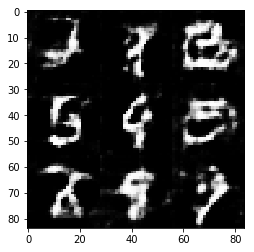

Epoch 0/2 Batch Step 1210... Discriminator Loss: 0.8132... Generator Loss: 3.0562
Epoch 0/2 Batch Step 1220... Discriminator Loss: 0.7255... Generator Loss: 1.2896
Epoch 0/2 Batch Step 1230... Discriminator Loss: 1.0085... Generator Loss: 1.3545
Epoch 0/2 Batch Step 1240... Discriminator Loss: 0.8630... Generator Loss: 2.4958
Epoch 0/2 Batch Step 1250... Discriminator Loss: 1.4615... Generator Loss: 0.7709
Epoch 0/2 Batch Step 1260... Discriminator Loss: 0.8594... Generator Loss: 1.8489
Epoch 0/2 Batch Step 1270... Discriminator Loss: 0.7637... Generator Loss: 1.0324
Epoch 0/2 Batch Step 1280... Discriminator Loss: 0.8384... Generator Loss: 2.3734
Epoch 0/2 Batch Step 1290... Discriminator Loss: 0.9273... Generator Loss: 1.6181
Epoch 0/2 Batch Step 1300... Discriminator Loss: 0.9645... Generator Loss: 2.1658


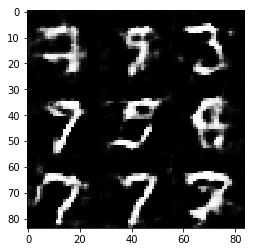

Epoch 0/2 Batch Step 1310... Discriminator Loss: 0.8001... Generator Loss: 2.3079
Epoch 0/2 Batch Step 1320... Discriminator Loss: 0.6532... Generator Loss: 2.2194
Epoch 0/2 Batch Step 1330... Discriminator Loss: 0.9013... Generator Loss: 3.0180
Epoch 0/2 Batch Step 1340... Discriminator Loss: 1.0979... Generator Loss: 0.9589
Epoch 0/2 Batch Step 1350... Discriminator Loss: 0.9444... Generator Loss: 1.9607
Epoch 0/2 Batch Step 1360... Discriminator Loss: 1.2298... Generator Loss: 0.7362
Epoch 0/2 Batch Step 1370... Discriminator Loss: 1.0422... Generator Loss: 1.9715
Epoch 0/2 Batch Step 1380... Discriminator Loss: 0.8303... Generator Loss: 0.8951
Epoch 0/2 Batch Step 1390... Discriminator Loss: 0.9544... Generator Loss: 1.2766
Epoch 0/2 Batch Step 1400... Discriminator Loss: 0.6415... Generator Loss: 0.6920


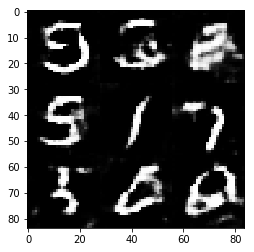

Epoch 0/2 Batch Step 1410... Discriminator Loss: 0.6394... Generator Loss: 1.3118
Epoch 0/2 Batch Step 1420... Discriminator Loss: 0.7151... Generator Loss: 1.4841
Epoch 0/2 Batch Step 1430... Discriminator Loss: 1.0863... Generator Loss: 1.3718
Epoch 0/2 Batch Step 1440... Discriminator Loss: 0.7382... Generator Loss: 1.5527
Epoch 0/2 Batch Step 1450... Discriminator Loss: 0.6201... Generator Loss: 2.5802
Epoch 0/2 Batch Step 1460... Discriminator Loss: 0.6558... Generator Loss: 2.8739
Epoch 0/2 Batch Step 1470... Discriminator Loss: 0.8041... Generator Loss: 1.3144
Epoch 0/2 Batch Step 1480... Discriminator Loss: 0.7160... Generator Loss: 1.2859
Epoch 0/2 Batch Step 1490... Discriminator Loss: 0.7770... Generator Loss: 1.0003
Epoch 0/2 Batch Step 1500... Discriminator Loss: 0.8481... Generator Loss: 2.1671


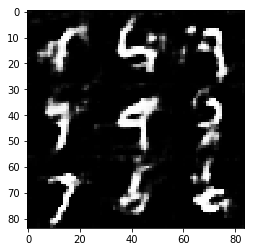

Epoch 0/2 Batch Step 1510... Discriminator Loss: 0.8103... Generator Loss: 1.1105
Epoch 0/2 Batch Step 1520... Discriminator Loss: 0.7401... Generator Loss: 2.1070
Epoch 0/2 Batch Step 1530... Discriminator Loss: 0.6610... Generator Loss: 2.6982
Epoch 0/2 Batch Step 1540... Discriminator Loss: 0.6011... Generator Loss: 2.1267
Epoch 0/2 Batch Step 1550... Discriminator Loss: 0.8992... Generator Loss: 0.8379
Epoch 0/2 Batch Step 1560... Discriminator Loss: 1.2124... Generator Loss: 3.3124
Epoch 0/2 Batch Step 1570... Discriminator Loss: 0.7765... Generator Loss: 1.1868
Epoch 0/2 Batch Step 1580... Discriminator Loss: 0.7927... Generator Loss: 2.0104
Epoch 0/2 Batch Step 1590... Discriminator Loss: 0.7039... Generator Loss: 1.4320
Epoch 0/2 Batch Step 1600... Discriminator Loss: 1.2704... Generator Loss: 1.1165


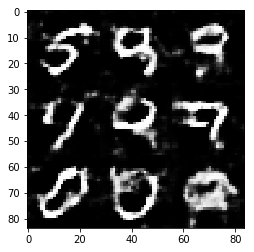

Epoch 0/2 Batch Step 1610... Discriminator Loss: 0.6702... Generator Loss: 0.9607
Epoch 0/2 Batch Step 1620... Discriminator Loss: 0.5561... Generator Loss: 1.4058
Epoch 0/2 Batch Step 1630... Discriminator Loss: 0.7487... Generator Loss: 1.3263
Epoch 0/2 Batch Step 1640... Discriminator Loss: 1.0795... Generator Loss: 0.8275
Epoch 0/2 Batch Step 1650... Discriminator Loss: 0.5133... Generator Loss: 2.9230
Epoch 0/2 Batch Step 1660... Discriminator Loss: 1.0055... Generator Loss: 2.6404
Epoch 0/2 Batch Step 1670... Discriminator Loss: 0.8246... Generator Loss: 0.8838
Epoch 0/2 Batch Step 1680... Discriminator Loss: 0.7600... Generator Loss: 0.9646
Epoch 0/2 Batch Step 1690... Discriminator Loss: 0.7896... Generator Loss: 1.4655
Epoch 0/2 Batch Step 1700... Discriminator Loss: 0.7149... Generator Loss: 0.7593


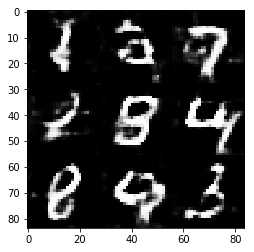

Epoch 0/2 Batch Step 1710... Discriminator Loss: 0.5496... Generator Loss: 2.4693
Epoch 0/2 Batch Step 1720... Discriminator Loss: 0.7364... Generator Loss: 1.2213
Epoch 0/2 Batch Step 1730... Discriminator Loss: 0.8154... Generator Loss: 1.0283
Epoch 0/2 Batch Step 1740... Discriminator Loss: 0.6110... Generator Loss: 3.6975
Epoch 0/2 Batch Step 1750... Discriminator Loss: 0.7213... Generator Loss: 2.2969
Epoch 0/2 Batch Step 1760... Discriminator Loss: 0.9804... Generator Loss: 2.2737
Epoch 0/2 Batch Step 1770... Discriminator Loss: 0.8379... Generator Loss: 1.5798
Epoch 0/2 Batch Step 1780... Discriminator Loss: 0.6142... Generator Loss: 1.5409
Epoch 0/2 Batch Step 1790... Discriminator Loss: 0.6106... Generator Loss: 2.0826
Epoch 0/2 Batch Step 1800... Discriminator Loss: 1.2465... Generator Loss: 0.9494


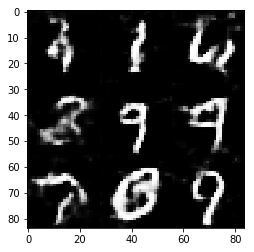

Epoch 0/2 Batch Step 1810... Discriminator Loss: 0.6270... Generator Loss: 1.9814
Epoch 0/2 Batch Step 1820... Discriminator Loss: 0.5539... Generator Loss: 2.0805
Epoch 0/2 Batch Step 1830... Discriminator Loss: 1.7569... Generator Loss: 0.4758
Epoch 0/2 Batch Step 1840... Discriminator Loss: 0.7753... Generator Loss: 2.1044
Epoch 0/2 Batch Step 1850... Discriminator Loss: 0.5844... Generator Loss: 1.7187
Epoch 0/2 Batch Step 1860... Discriminator Loss: 0.8492... Generator Loss: 1.0755
Epoch 0/2 Batch Step 1870... Discriminator Loss: 0.7777... Generator Loss: 2.5110
Epoch 0/2 Batch Step 1880... Discriminator Loss: 0.7209... Generator Loss: 3.0040
Epoch 0/2 Batch Step 1890... Discriminator Loss: 0.7041... Generator Loss: 1.8858
Epoch 0/2 Batch Step 1900... Discriminator Loss: 0.7013... Generator Loss: 1.4805


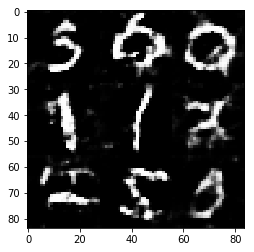

Epoch 0/2 Batch Step 1910... Discriminator Loss: 0.6069... Generator Loss: 1.3745
Epoch 0/2 Batch Step 1920... Discriminator Loss: 0.6018... Generator Loss: 2.0872
Epoch 0/2 Batch Step 1930... Discriminator Loss: 0.5262... Generator Loss: 3.1111
Epoch 0/2 Batch Step 1940... Discriminator Loss: 0.7831... Generator Loss: 3.7908
Epoch 0/2 Batch Step 1950... Discriminator Loss: 0.9431... Generator Loss: 2.1059
Epoch 0/2 Batch Step 1960... Discriminator Loss: 0.5866... Generator Loss: 1.8160
Epoch 0/2 Batch Step 1970... Discriminator Loss: 1.3254... Generator Loss: 3.3295
Epoch 0/2 Batch Step 1980... Discriminator Loss: 0.6788... Generator Loss: 1.8773
Epoch 0/2 Batch Step 1990... Discriminator Loss: 0.9236... Generator Loss: 1.1819
Epoch 0/2 Batch Step 2000... Discriminator Loss: 0.6296... Generator Loss: 1.1683


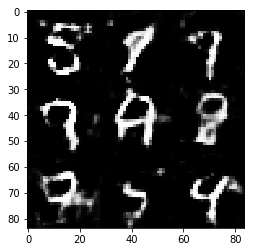

Epoch 0/2 Batch Step 2010... Discriminator Loss: 0.6662... Generator Loss: 0.9989
Epoch 0/2 Batch Step 2020... Discriminator Loss: 0.5943... Generator Loss: 2.5114
Epoch 0/2 Batch Step 2030... Discriminator Loss: 0.7380... Generator Loss: 1.2319
Epoch 0/2 Batch Step 2040... Discriminator Loss: 0.5801... Generator Loss: 2.2266
Epoch 0/2 Batch Step 2050... Discriminator Loss: 1.0123... Generator Loss: 0.9333
Epoch 0/2 Batch Step 2060... Discriminator Loss: 0.5772... Generator Loss: 1.9891
Epoch 0/2 Batch Step 2070... Discriminator Loss: 0.5340... Generator Loss: 2.4289
Epoch 0/2 Batch Step 2080... Discriminator Loss: 0.6436... Generator Loss: 1.3409
Epoch 0/2 Batch Step 2090... Discriminator Loss: 0.7550... Generator Loss: 1.4108
Epoch 0/2 Batch Step 2100... Discriminator Loss: 0.5970... Generator Loss: 1.3289


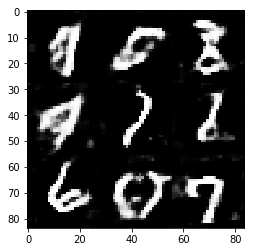

Epoch 0/2 Batch Step 2110... Discriminator Loss: 0.6940... Generator Loss: 1.5220
Epoch 0/2 Batch Step 2120... Discriminator Loss: 0.8735... Generator Loss: 2.3761
Epoch 0/2 Batch Step 2130... Discriminator Loss: 0.4473... Generator Loss: 3.3852
Epoch 0/2 Batch Step 2140... Discriminator Loss: 0.6157... Generator Loss: 1.7653
Epoch 0/2 Batch Step 2150... Discriminator Loss: 0.6510... Generator Loss: 2.3328
Epoch 0/2 Batch Step 2160... Discriminator Loss: 0.7586... Generator Loss: 1.8187
Epoch 0/2 Batch Step 2170... Discriminator Loss: 0.8558... Generator Loss: 3.2290
Epoch 0/2 Batch Step 2180... Discriminator Loss: 0.7714... Generator Loss: 2.0187
Epoch 0/2 Batch Step 2190... Discriminator Loss: 0.5011... Generator Loss: 1.4906
Epoch 0/2 Batch Step 2200... Discriminator Loss: 1.2356... Generator Loss: 0.7829


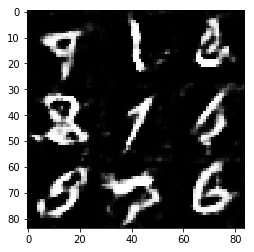

Epoch 0/2 Batch Step 2210... Discriminator Loss: 1.0996... Generator Loss: 3.3424
Epoch 0/2 Batch Step 2220... Discriminator Loss: 1.0142... Generator Loss: 0.9926
Epoch 0/2 Batch Step 2230... Discriminator Loss: 0.9589... Generator Loss: 2.2517
Epoch 0/2 Batch Step 2240... Discriminator Loss: 0.7689... Generator Loss: 2.6380
Epoch 0/2 Batch Step 2250... Discriminator Loss: 0.5934... Generator Loss: 2.4993
Epoch 0/2 Batch Step 2260... Discriminator Loss: 0.5878... Generator Loss: 1.2478
Epoch 0/2 Batch Step 2270... Discriminator Loss: 0.6492... Generator Loss: 2.3461
Epoch 0/2 Batch Step 2280... Discriminator Loss: 0.5059... Generator Loss: 2.2103
Epoch 0/2 Batch Step 2290... Discriminator Loss: 0.5994... Generator Loss: 2.9493
Epoch 0/2 Batch Step 2300... Discriminator Loss: 0.5779... Generator Loss: 2.0254


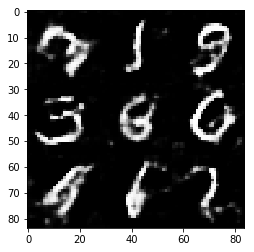

Epoch 0/2 Batch Step 2310... Discriminator Loss: 1.1778... Generator Loss: 1.4997
Epoch 0/2 Batch Step 2320... Discriminator Loss: 0.6297... Generator Loss: 1.8194
Epoch 0/2 Batch Step 2330... Discriminator Loss: 0.5819... Generator Loss: 2.7489
Epoch 0/2 Batch Step 2340... Discriminator Loss: 0.6039... Generator Loss: 1.9213
Epoch 0/2 Batch Step 2350... Discriminator Loss: 0.6780... Generator Loss: 0.9401
Epoch 0/2 Batch Step 2360... Discriminator Loss: 0.5149... Generator Loss: 3.9419
Epoch 0/2 Batch Step 2370... Discriminator Loss: 0.6976... Generator Loss: 2.0208
Epoch 0/2 Batch Step 2380... Discriminator Loss: 1.0516... Generator Loss: 2.8456
Epoch 0/2 Batch Step 2390... Discriminator Loss: 0.5889... Generator Loss: 0.7199
Epoch 0/2 Batch Step 2400... Discriminator Loss: 0.4803... Generator Loss: 2.1339


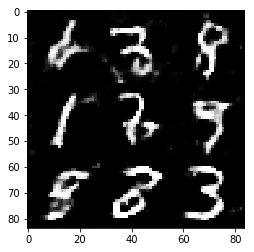

Epoch 0/2 Batch Step 2410... Discriminator Loss: 0.4035... Generator Loss: 1.4586
Epoch 0/2 Batch Step 2420... Discriminator Loss: 0.6085... Generator Loss: 2.0496
Epoch 0/2 Batch Step 2430... Discriminator Loss: 0.9396... Generator Loss: 1.2548
Epoch 0/2 Batch Step 2440... Discriminator Loss: 0.4657... Generator Loss: 1.6801
Epoch 0/2 Batch Step 2450... Discriminator Loss: 0.6560... Generator Loss: 2.6707
Epoch 0/2 Batch Step 2460... Discriminator Loss: 0.7531... Generator Loss: 1.6267
Epoch 0/2 Batch Step 2470... Discriminator Loss: 0.4190... Generator Loss: 2.0224
Epoch 0/2 Batch Step 2480... Discriminator Loss: 0.5875... Generator Loss: 2.7250
Epoch 0/2 Batch Step 2490... Discriminator Loss: 0.6115... Generator Loss: 2.6383
Epoch 0/2 Batch Step 2500... Discriminator Loss: 0.5065... Generator Loss: 1.4929


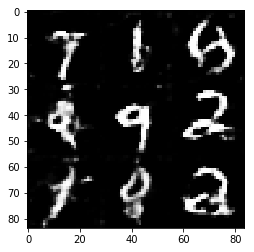

Epoch 0/2 Batch Step 2510... Discriminator Loss: 0.7907... Generator Loss: 0.9425
Epoch 0/2 Batch Step 2520... Discriminator Loss: 0.8883... Generator Loss: 1.0362
Epoch 0/2 Batch Step 2530... Discriminator Loss: 0.6209... Generator Loss: 3.9144
Epoch 0/2 Batch Step 2540... Discriminator Loss: 0.4415... Generator Loss: 2.5504
Epoch 0/2 Batch Step 2550... Discriminator Loss: 0.7835... Generator Loss: 1.9446
Epoch 0/2 Batch Step 2560... Discriminator Loss: 0.6909... Generator Loss: 2.5402
Epoch 0/2 Batch Step 2570... Discriminator Loss: 0.8896... Generator Loss: 1.4317
Epoch 0/2 Batch Step 2580... Discriminator Loss: 0.8237... Generator Loss: 3.2123
Epoch 0/2 Batch Step 2590... Discriminator Loss: 0.7860... Generator Loss: 1.5430
Epoch 0/2 Batch Step 2600... Discriminator Loss: 0.8131... Generator Loss: 3.9645


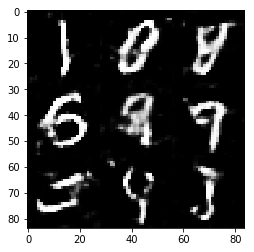

Epoch 0/2 Batch Step 2610... Discriminator Loss: 0.4892... Generator Loss: 2.1595
Epoch 0/2 Batch Step 2620... Discriminator Loss: 0.6491... Generator Loss: 1.9546
Epoch 0/2 Batch Step 2630... Discriminator Loss: 0.6702... Generator Loss: 1.2251
Epoch 0/2 Batch Step 2640... Discriminator Loss: 0.4930... Generator Loss: 2.1390
Epoch 0/2 Batch Step 2650... Discriminator Loss: 0.5995... Generator Loss: 1.5573
Epoch 0/2 Batch Step 2660... Discriminator Loss: 0.6301... Generator Loss: 1.6782
Epoch 0/2 Batch Step 2670... Discriminator Loss: 0.8294... Generator Loss: 2.6638
Epoch 0/2 Batch Step 2680... Discriminator Loss: 0.4155... Generator Loss: 2.4467
Epoch 0/2 Batch Step 2690... Discriminator Loss: 0.5899... Generator Loss: 2.6249
Epoch 0/2 Batch Step 2700... Discriminator Loss: 0.5003... Generator Loss: 3.5952


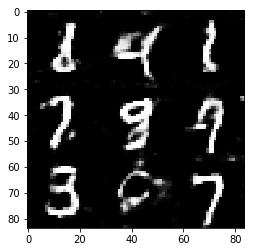

Epoch 0/2 Batch Step 2710... Discriminator Loss: 0.4777... Generator Loss: 1.6255
Epoch 0/2 Batch Step 2720... Discriminator Loss: 0.5078... Generator Loss: 1.5634
Epoch 0/2 Batch Step 2730... Discriminator Loss: 0.6728... Generator Loss: 1.8126
Epoch 0/2 Batch Step 2740... Discriminator Loss: 0.5216... Generator Loss: 2.2424
Epoch 0/2 Batch Step 2750... Discriminator Loss: 0.5822... Generator Loss: 2.7322
Epoch 0/2 Batch Step 2760... Discriminator Loss: 0.6071... Generator Loss: 2.2410
Epoch 0/2 Batch Step 2770... Discriminator Loss: 0.4832... Generator Loss: 2.8267
Epoch 0/2 Batch Step 2780... Discriminator Loss: 0.5769... Generator Loss: 2.1554
Epoch 0/2 Batch Step 2790... Discriminator Loss: 0.8932... Generator Loss: 1.1487
Epoch 0/2 Batch Step 2800... Discriminator Loss: 0.4936... Generator Loss: 2.2309


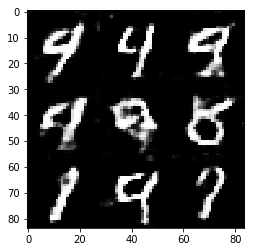

Epoch 0/2 Batch Step 2810... Discriminator Loss: 0.6138... Generator Loss: 2.3214
Epoch 0/2 Batch Step 2820... Discriminator Loss: 0.5190... Generator Loss: 2.1446
Epoch 0/2 Batch Step 2830... Discriminator Loss: 0.5185... Generator Loss: 1.7901
Epoch 0/2 Batch Step 2840... Discriminator Loss: 0.7415... Generator Loss: 3.7065
Epoch 0/2 Batch Step 2850... Discriminator Loss: 0.4411... Generator Loss: 2.4209
Epoch 0/2 Batch Step 2860... Discriminator Loss: 0.7711... Generator Loss: 3.6252
Epoch 0/2 Batch Step 2870... Discriminator Loss: 0.4949... Generator Loss: 1.7710
Epoch 0/2 Batch Step 2880... Discriminator Loss: 0.7819... Generator Loss: 0.7594
Epoch 0/2 Batch Step 2890... Discriminator Loss: 0.5097... Generator Loss: 3.4460
Epoch 0/2 Batch Step 2900... Discriminator Loss: 0.4658... Generator Loss: 3.2772


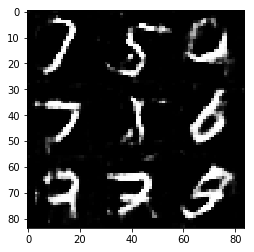

Epoch 0/2 Batch Step 2910... Discriminator Loss: 0.4771... Generator Loss: 4.6290
Epoch 0/2 Batch Step 2920... Discriminator Loss: 0.6383... Generator Loss: 2.1715
Epoch 0/2 Batch Step 2930... Discriminator Loss: 0.7928... Generator Loss: 1.8185
Epoch 0/2 Batch Step 2940... Discriminator Loss: 1.2903... Generator Loss: 1.5550
Epoch 0/2 Batch Step 2950... Discriminator Loss: 0.5101... Generator Loss: 4.7004
Epoch 0/2 Batch Step 2960... Discriminator Loss: 0.3980... Generator Loss: 2.6767
Epoch 0/2 Batch Step 2970... Discriminator Loss: 0.6069... Generator Loss: 2.7507
Epoch 0/2 Batch Step 2980... Discriminator Loss: 0.5036... Generator Loss: 1.5986
Epoch 0/2 Batch Step 2990... Discriminator Loss: 0.4508... Generator Loss: 2.7282
Epoch 0/2 Batch Step 3000... Discriminator Loss: 0.3636... Generator Loss: 4.3592


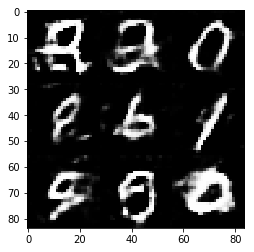

Epoch 0/2 Batch Step 3010... Discriminator Loss: 0.4270... Generator Loss: 4.3522
Epoch 0/2 Batch Step 3020... Discriminator Loss: 0.5611... Generator Loss: 1.7795
Epoch 0/2 Batch Step 3030... Discriminator Loss: 0.4258... Generator Loss: 3.8215
Epoch 0/2 Batch Step 3040... Discriminator Loss: 0.4038... Generator Loss: 4.8987
Epoch 0/2 Batch Step 3050... Discriminator Loss: 0.3976... Generator Loss: 4.0364
Epoch 0/2 Batch Step 3060... Discriminator Loss: 0.4418... Generator Loss: 4.0222
Epoch 0/2 Batch Step 3070... Discriminator Loss: 0.4909... Generator Loss: 3.6976
Epoch 0/2 Batch Step 3080... Discriminator Loss: 0.5332... Generator Loss: 3.9368
Epoch 0/2 Batch Step 3090... Discriminator Loss: 0.3990... Generator Loss: 3.5346
Epoch 0/2 Batch Step 3100... Discriminator Loss: 0.7082... Generator Loss: 2.2533


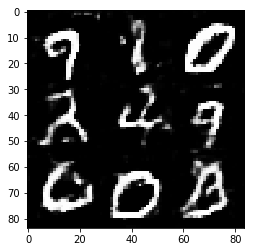

Epoch 0/2 Batch Step 3110... Discriminator Loss: 0.3696... Generator Loss: 4.1038
Epoch 0/2 Batch Step 3120... Discriminator Loss: 0.4180... Generator Loss: 2.4958
Epoch 0/2 Batch Step 3130... Discriminator Loss: 0.5748... Generator Loss: 2.4196
Epoch 0/2 Batch Step 3140... Discriminator Loss: 0.6349... Generator Loss: 1.8808
Epoch 0/2 Batch Step 3150... Discriminator Loss: 0.5118... Generator Loss: 2.3112
Epoch 0/2 Batch Step 3160... Discriminator Loss: 0.4631... Generator Loss: 1.4759
Epoch 0/2 Batch Step 3170... Discriminator Loss: 0.3735... Generator Loss: 3.6589
Epoch 0/2 Batch Step 3180... Discriminator Loss: 0.4440... Generator Loss: 4.4466
Epoch 0/2 Batch Step 3190... Discriminator Loss: 0.5320... Generator Loss: 2.3662
Epoch 0/2 Batch Step 3200... Discriminator Loss: 0.4934... Generator Loss: 3.0199


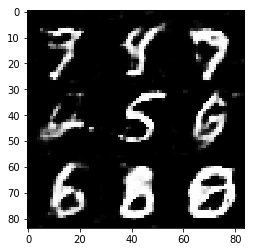

Epoch 0/2 Batch Step 3210... Discriminator Loss: 0.3902... Generator Loss: 2.6200
Epoch 0/2 Batch Step 3220... Discriminator Loss: 0.8479... Generator Loss: 3.4283
Epoch 0/2 Batch Step 3230... Discriminator Loss: 0.7297... Generator Loss: 3.4186
Epoch 0/2 Batch Step 3240... Discriminator Loss: 0.5113... Generator Loss: 1.3049
Epoch 0/2 Batch Step 3250... Discriminator Loss: 0.4975... Generator Loss: 2.0137
Epoch 0/2 Batch Step 3260... Discriminator Loss: 0.5239... Generator Loss: 2.9583
Epoch 0/2 Batch Step 3270... Discriminator Loss: 0.5133... Generator Loss: 2.5889
Epoch 0/2 Batch Step 3280... Discriminator Loss: 0.3815... Generator Loss: 3.0575
Epoch 0/2 Batch Step 3290... Discriminator Loss: 0.4515... Generator Loss: 2.0314
Epoch 0/2 Batch Step 3300... Discriminator Loss: 0.4078... Generator Loss: 2.5211


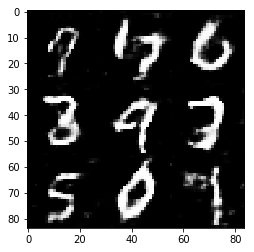

Epoch 0/2 Batch Step 3310... Discriminator Loss: 0.6518... Generator Loss: 0.7083
Epoch 0/2 Batch Step 3320... Discriminator Loss: 0.4113... Generator Loss: 2.2510
Epoch 0/2 Batch Step 3330... Discriminator Loss: 0.5876... Generator Loss: 2.4392
Epoch 0/2 Batch Step 3340... Discriminator Loss: 0.7055... Generator Loss: 3.8764
Epoch 0/2 Batch Step 3350... Discriminator Loss: 0.4759... Generator Loss: 1.4825
Epoch 0/2 Batch Step 3360... Discriminator Loss: 0.5189... Generator Loss: 1.8487
Epoch 0/2 Batch Step 3370... Discriminator Loss: 0.3824... Generator Loss: 2.1465
Epoch 0/2 Batch Step 3380... Discriminator Loss: 0.4369... Generator Loss: 2.5161
Epoch 0/2 Batch Step 3390... Discriminator Loss: 0.7275... Generator Loss: 2.5381
Epoch 0/2 Batch Step 3400... Discriminator Loss: 0.3967... Generator Loss: 2.7345


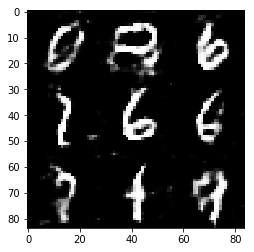

Epoch 0/2 Batch Step 3410... Discriminator Loss: 0.3910... Generator Loss: 3.3761
Epoch 0/2 Batch Step 3420... Discriminator Loss: 1.4985... Generator Loss: 0.4883
Epoch 0/2 Batch Step 3430... Discriminator Loss: 0.3914... Generator Loss: 3.8679
Epoch 0/2 Batch Step 3440... Discriminator Loss: 0.5933... Generator Loss: 1.7888
Epoch 0/2 Batch Step 3450... Discriminator Loss: 0.5117... Generator Loss: 2.9496
Epoch 0/2 Batch Step 3460... Discriminator Loss: 0.6226... Generator Loss: 2.7861
Epoch 0/2 Batch Step 3470... Discriminator Loss: 0.6157... Generator Loss: 2.8823
Epoch 0/2 Batch Step 3480... Discriminator Loss: 0.3605... Generator Loss: 3.2586
Epoch 0/2 Batch Step 3490... Discriminator Loss: 0.3801... Generator Loss: 4.6168
Epoch 0/2 Batch Step 3500... Discriminator Loss: 0.4227... Generator Loss: 2.7315


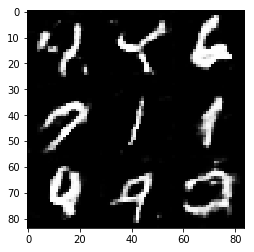

Epoch 0/2 Batch Step 3510... Discriminator Loss: 0.4715... Generator Loss: 2.9094
Epoch 0/2 Batch Step 3520... Discriminator Loss: 0.5515... Generator Loss: 4.4700
Epoch 0/2 Batch Step 3530... Discriminator Loss: 0.4990... Generator Loss: 1.7150
Epoch 0/2 Batch Step 3540... Discriminator Loss: 0.5198... Generator Loss: 4.0968
Epoch 0/2 Batch Step 3550... Discriminator Loss: 0.4873... Generator Loss: 1.8631
Epoch 0/2 Batch Step 3560... Discriminator Loss: 0.4115... Generator Loss: 3.6718
Epoch 0/2 Batch Step 3570... Discriminator Loss: 0.3943... Generator Loss: 3.5314
Epoch 0/2 Batch Step 3580... Discriminator Loss: 0.7048... Generator Loss: 2.4033
Epoch 0/2 Batch Step 3590... Discriminator Loss: 0.5099... Generator Loss: 2.3912
Epoch 0/2 Batch Step 3600... Discriminator Loss: 0.4122... Generator Loss: 3.0039


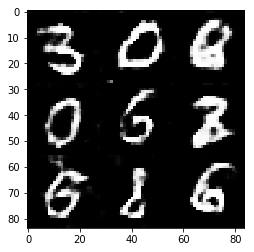

Epoch 0/2 Batch Step 3610... Discriminator Loss: 0.8814... Generator Loss: 1.4033
Epoch 0/2 Batch Step 3620... Discriminator Loss: 0.4785... Generator Loss: 2.1404
Epoch 0/2 Batch Step 3630... Discriminator Loss: 0.3776... Generator Loss: 4.0202
Epoch 0/2 Batch Step 3640... Discriminator Loss: 0.4902... Generator Loss: 3.1055
Epoch 0/2 Batch Step 3650... Discriminator Loss: 0.8560... Generator Loss: 1.5600
Epoch 0/2 Batch Step 3660... Discriminator Loss: 0.4555... Generator Loss: 1.1529
Epoch 0/2 Batch Step 3670... Discriminator Loss: 0.4323... Generator Loss: 2.7780
Epoch 0/2 Batch Step 3680... Discriminator Loss: 0.5098... Generator Loss: 3.1793
Epoch 0/2 Batch Step 3690... Discriminator Loss: 0.4332... Generator Loss: 3.9018
Epoch 0/2 Batch Step 3700... Discriminator Loss: 0.4597... Generator Loss: 3.4800


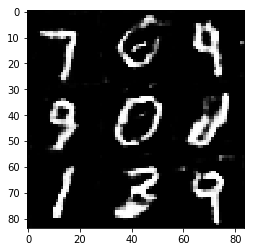

Epoch 0/2 Batch Step 3710... Discriminator Loss: 0.5183... Generator Loss: 3.5306
Epoch 0/2 Batch Step 3720... Discriminator Loss: 0.5191... Generator Loss: 2.9194
Epoch 0/2 Batch Step 3730... Discriminator Loss: 0.4914... Generator Loss: 1.9704
Epoch 0/2 Batch Step 3740... Discriminator Loss: 0.5611... Generator Loss: 2.5151
Epoch 0/2 Batch Step 3750... Discriminator Loss: 0.3860... Generator Loss: 4.3237
Epoch 1/2 Batch Step 3760... Discriminator Loss: 0.4061... Generator Loss: 3.6724
Epoch 1/2 Batch Step 3770... Discriminator Loss: 0.4408... Generator Loss: 3.3004
Epoch 1/2 Batch Step 3780... Discriminator Loss: 0.4401... Generator Loss: 3.1741
Epoch 1/2 Batch Step 3790... Discriminator Loss: 0.4510... Generator Loss: 3.3664
Epoch 1/2 Batch Step 3800... Discriminator Loss: 0.4336... Generator Loss: 3.1731


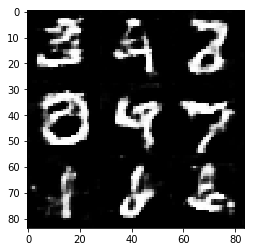

Epoch 1/2 Batch Step 3810... Discriminator Loss: 0.6262... Generator Loss: 3.3289
Epoch 1/2 Batch Step 3820... Discriminator Loss: 0.3920... Generator Loss: 3.2894
Epoch 1/2 Batch Step 3830... Discriminator Loss: 0.4967... Generator Loss: 2.3130
Epoch 1/2 Batch Step 3840... Discriminator Loss: 0.5823... Generator Loss: 2.4252
Epoch 1/2 Batch Step 3850... Discriminator Loss: 0.4685... Generator Loss: 4.3293
Epoch 1/2 Batch Step 3860... Discriminator Loss: 0.6018... Generator Loss: 3.1948
Epoch 1/2 Batch Step 3870... Discriminator Loss: 0.4422... Generator Loss: 2.3849
Epoch 1/2 Batch Step 3880... Discriminator Loss: 0.4730... Generator Loss: 3.0936
Epoch 1/2 Batch Step 3890... Discriminator Loss: 0.4390... Generator Loss: 2.4828
Epoch 1/2 Batch Step 3900... Discriminator Loss: 0.6134... Generator Loss: 4.1090


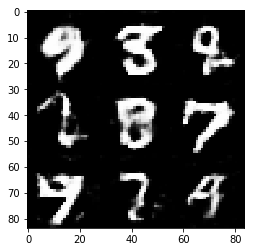

Epoch 1/2 Batch Step 3910... Discriminator Loss: 0.4245... Generator Loss: 3.1054
Epoch 1/2 Batch Step 3920... Discriminator Loss: 0.4857... Generator Loss: 2.1214
Epoch 1/2 Batch Step 3930... Discriminator Loss: 0.3990... Generator Loss: 2.6902
Epoch 1/2 Batch Step 3940... Discriminator Loss: 0.5562... Generator Loss: 2.2647
Epoch 1/2 Batch Step 3950... Discriminator Loss: 0.4659... Generator Loss: 1.9490
Epoch 1/2 Batch Step 3960... Discriminator Loss: 0.3743... Generator Loss: 3.4854
Epoch 1/2 Batch Step 3970... Discriminator Loss: 0.3960... Generator Loss: 2.5307
Epoch 1/2 Batch Step 3980... Discriminator Loss: 0.4248... Generator Loss: 2.8733
Epoch 1/2 Batch Step 3990... Discriminator Loss: 0.6093... Generator Loss: 1.9746
Epoch 1/2 Batch Step 4000... Discriminator Loss: 0.4133... Generator Loss: 3.1066


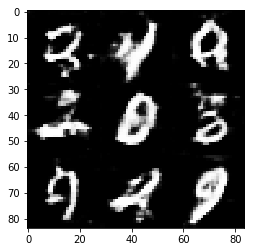

Epoch 1/2 Batch Step 4010... Discriminator Loss: 0.4499... Generator Loss: 2.2933
Epoch 1/2 Batch Step 4020... Discriminator Loss: 0.4375... Generator Loss: 2.4918
Epoch 1/2 Batch Step 4030... Discriminator Loss: 0.7300... Generator Loss: 1.5003
Epoch 1/2 Batch Step 4040... Discriminator Loss: 0.3858... Generator Loss: 3.0159
Epoch 1/2 Batch Step 4050... Discriminator Loss: 0.4225... Generator Loss: 2.3014
Epoch 1/2 Batch Step 4060... Discriminator Loss: 0.6685... Generator Loss: 6.8255
Epoch 1/2 Batch Step 4070... Discriminator Loss: 0.4001... Generator Loss: 2.5516
Epoch 1/2 Batch Step 4080... Discriminator Loss: 0.3964... Generator Loss: 3.2078
Epoch 1/2 Batch Step 4090... Discriminator Loss: 0.4082... Generator Loss: 2.3405
Epoch 1/2 Batch Step 4100... Discriminator Loss: 0.4739... Generator Loss: 1.5628


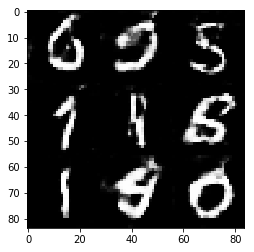

Epoch 1/2 Batch Step 4110... Discriminator Loss: 0.4110... Generator Loss: 2.5837
Epoch 1/2 Batch Step 4120... Discriminator Loss: 0.4833... Generator Loss: 2.8153
Epoch 1/2 Batch Step 4130... Discriminator Loss: 0.3586... Generator Loss: 5.7585
Epoch 1/2 Batch Step 4140... Discriminator Loss: 0.5535... Generator Loss: 3.9429
Epoch 1/2 Batch Step 4150... Discriminator Loss: 1.0337... Generator Loss: 3.2123
Epoch 1/2 Batch Step 4160... Discriminator Loss: 0.5624... Generator Loss: 2.3533
Epoch 1/2 Batch Step 4170... Discriminator Loss: 0.3623... Generator Loss: 4.9754
Epoch 1/2 Batch Step 4180... Discriminator Loss: 0.4144... Generator Loss: 3.4024
Epoch 1/2 Batch Step 4190... Discriminator Loss: 0.3732... Generator Loss: 3.5514
Epoch 1/2 Batch Step 4200... Discriminator Loss: 1.1087... Generator Loss: 1.1869


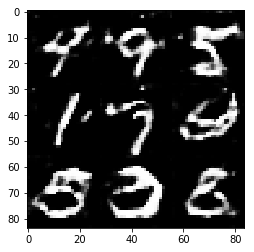

Epoch 1/2 Batch Step 4210... Discriminator Loss: 0.4290... Generator Loss: 3.7219
Epoch 1/2 Batch Step 4220... Discriminator Loss: 0.4349... Generator Loss: 2.4450
Epoch 1/2 Batch Step 4230... Discriminator Loss: 0.6855... Generator Loss: 3.6259
Epoch 1/2 Batch Step 4240... Discriminator Loss: 0.4552... Generator Loss: 4.1901
Epoch 1/2 Batch Step 4250... Discriminator Loss: 0.4102... Generator Loss: 4.6621
Epoch 1/2 Batch Step 4260... Discriminator Loss: 0.6024... Generator Loss: 3.1499
Epoch 1/2 Batch Step 4270... Discriminator Loss: 0.5875... Generator Loss: 2.6381
Epoch 1/2 Batch Step 4280... Discriminator Loss: 0.6467... Generator Loss: 3.4674
Epoch 1/2 Batch Step 4290... Discriminator Loss: 0.4048... Generator Loss: 3.2093
Epoch 1/2 Batch Step 4300... Discriminator Loss: 0.3655... Generator Loss: 2.4126


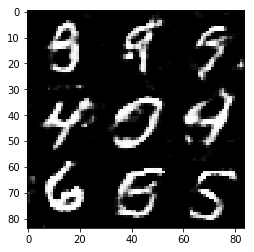

Epoch 1/2 Batch Step 4310... Discriminator Loss: 0.3728... Generator Loss: 3.9113
Epoch 1/2 Batch Step 4320... Discriminator Loss: 0.4735... Generator Loss: 1.7963
Epoch 1/2 Batch Step 4330... Discriminator Loss: 0.5520... Generator Loss: 6.4260
Epoch 1/2 Batch Step 4340... Discriminator Loss: 0.3730... Generator Loss: 2.1491
Epoch 1/2 Batch Step 4350... Discriminator Loss: 0.4850... Generator Loss: 2.2075
Epoch 1/2 Batch Step 4360... Discriminator Loss: 0.5234... Generator Loss: 2.9504
Epoch 1/2 Batch Step 4370... Discriminator Loss: 0.5913... Generator Loss: 3.8747
Epoch 1/2 Batch Step 4380... Discriminator Loss: 0.4973... Generator Loss: 2.6743
Epoch 1/2 Batch Step 4390... Discriminator Loss: 0.4179... Generator Loss: 1.8569
Epoch 1/2 Batch Step 4400... Discriminator Loss: 0.4754... Generator Loss: 1.5622


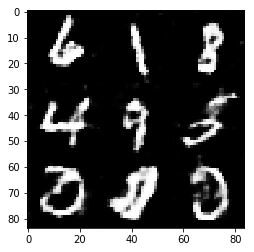

Epoch 1/2 Batch Step 4410... Discriminator Loss: 0.5238... Generator Loss: 1.5856
Epoch 1/2 Batch Step 4420... Discriminator Loss: 0.4399... Generator Loss: 2.5430
Epoch 1/2 Batch Step 4430... Discriminator Loss: 0.4670... Generator Loss: 2.2590
Epoch 1/2 Batch Step 4440... Discriminator Loss: 0.4659... Generator Loss: 2.5712
Epoch 1/2 Batch Step 4450... Discriminator Loss: 0.4032... Generator Loss: 3.2430
Epoch 1/2 Batch Step 4460... Discriminator Loss: 0.4436... Generator Loss: 2.0563
Epoch 1/2 Batch Step 4470... Discriminator Loss: 0.4656... Generator Loss: 2.2773
Epoch 1/2 Batch Step 4480... Discriminator Loss: 0.3641... Generator Loss: 4.7115
Epoch 1/2 Batch Step 4490... Discriminator Loss: 0.7246... Generator Loss: 1.3941
Epoch 1/2 Batch Step 4500... Discriminator Loss: 0.5321... Generator Loss: 3.0081


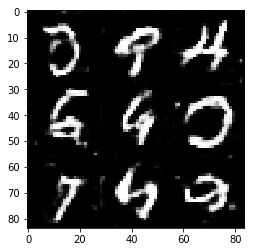

Epoch 1/2 Batch Step 4510... Discriminator Loss: 0.4563... Generator Loss: 4.2428
Epoch 1/2 Batch Step 4520... Discriminator Loss: 0.5474... Generator Loss: 1.2638
Epoch 1/2 Batch Step 4530... Discriminator Loss: 0.3743... Generator Loss: 4.3504
Epoch 1/2 Batch Step 4540... Discriminator Loss: 0.5402... Generator Loss: 1.8430
Epoch 1/2 Batch Step 4550... Discriminator Loss: 0.6575... Generator Loss: 2.0480
Epoch 1/2 Batch Step 4560... Discriminator Loss: 0.4357... Generator Loss: 2.6525
Epoch 1/2 Batch Step 4570... Discriminator Loss: 0.3970... Generator Loss: 4.2397
Epoch 1/2 Batch Step 4580... Discriminator Loss: 0.4597... Generator Loss: 3.1152
Epoch 1/2 Batch Step 4590... Discriminator Loss: 1.1432... Generator Loss: 2.3361
Epoch 1/2 Batch Step 4600... Discriminator Loss: 0.3931... Generator Loss: 3.3144


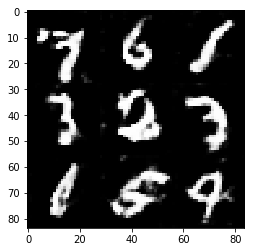

Epoch 1/2 Batch Step 4610... Discriminator Loss: 0.3903... Generator Loss: 3.3020
Epoch 1/2 Batch Step 4620... Discriminator Loss: 0.4242... Generator Loss: 3.9350
Epoch 1/2 Batch Step 4630... Discriminator Loss: 0.4182... Generator Loss: 3.4082
Epoch 1/2 Batch Step 4640... Discriminator Loss: 0.3851... Generator Loss: 3.4948
Epoch 1/2 Batch Step 4650... Discriminator Loss: 0.4650... Generator Loss: 2.7906
Epoch 1/2 Batch Step 4660... Discriminator Loss: 0.6066... Generator Loss: 2.2423
Epoch 1/2 Batch Step 4670... Discriminator Loss: 0.3794... Generator Loss: 3.3742
Epoch 1/2 Batch Step 4680... Discriminator Loss: 0.4097... Generator Loss: 3.4236
Epoch 1/2 Batch Step 4690... Discriminator Loss: 0.4651... Generator Loss: 3.1685
Epoch 1/2 Batch Step 4700... Discriminator Loss: 0.4497... Generator Loss: 4.2086


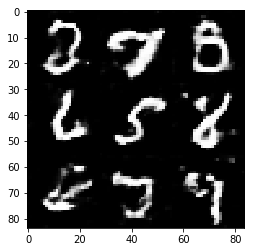

Epoch 1/2 Batch Step 4710... Discriminator Loss: 0.7422... Generator Loss: 1.9469
Epoch 1/2 Batch Step 4720... Discriminator Loss: 0.6010... Generator Loss: 1.2285
Epoch 1/2 Batch Step 4730... Discriminator Loss: 0.7183... Generator Loss: 1.1726
Epoch 1/2 Batch Step 4740... Discriminator Loss: 0.4096... Generator Loss: 2.3440
Epoch 1/2 Batch Step 4750... Discriminator Loss: 0.4509... Generator Loss: 2.5965
Epoch 1/2 Batch Step 4760... Discriminator Loss: 0.4434... Generator Loss: 3.0225
Epoch 1/2 Batch Step 4770... Discriminator Loss: 0.4350... Generator Loss: 4.0233
Epoch 1/2 Batch Step 4780... Discriminator Loss: 0.4288... Generator Loss: 4.0483
Epoch 1/2 Batch Step 4790... Discriminator Loss: 0.4340... Generator Loss: 2.3729
Epoch 1/2 Batch Step 4800... Discriminator Loss: 0.4831... Generator Loss: 2.7395


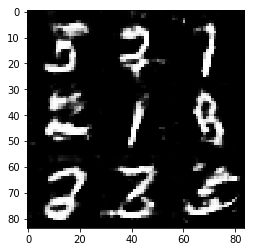

Epoch 1/2 Batch Step 4810... Discriminator Loss: 0.3942... Generator Loss: 3.5426
Epoch 1/2 Batch Step 4820... Discriminator Loss: 0.4477... Generator Loss: 3.6766
Epoch 1/2 Batch Step 4830... Discriminator Loss: 0.4409... Generator Loss: 2.9783
Epoch 1/2 Batch Step 4840... Discriminator Loss: 0.4688... Generator Loss: 3.0532
Epoch 1/2 Batch Step 4850... Discriminator Loss: 0.3802... Generator Loss: 4.5052
Epoch 1/2 Batch Step 4860... Discriminator Loss: 0.5534... Generator Loss: 2.7137
Epoch 1/2 Batch Step 4870... Discriminator Loss: 0.6125... Generator Loss: 3.1337
Epoch 1/2 Batch Step 4880... Discriminator Loss: 0.4230... Generator Loss: 2.6999
Epoch 1/2 Batch Step 4890... Discriminator Loss: 0.6154... Generator Loss: 1.9114
Epoch 1/2 Batch Step 4900... Discriminator Loss: 0.3907... Generator Loss: 6.8024


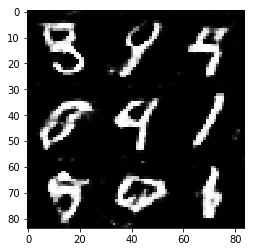

Epoch 1/2 Batch Step 4910... Discriminator Loss: 0.3846... Generator Loss: 3.2252
Epoch 1/2 Batch Step 4920... Discriminator Loss: 0.6684... Generator Loss: 3.7982
Epoch 1/2 Batch Step 4930... Discriminator Loss: 0.3806... Generator Loss: 2.1953
Epoch 1/2 Batch Step 4940... Discriminator Loss: 0.3762... Generator Loss: 3.2634
Epoch 1/2 Batch Step 4950... Discriminator Loss: 0.3531... Generator Loss: 6.2676
Epoch 1/2 Batch Step 4960... Discriminator Loss: 0.5191... Generator Loss: 3.7972
Epoch 1/2 Batch Step 4970... Discriminator Loss: 0.4251... Generator Loss: 3.2676
Epoch 1/2 Batch Step 4980... Discriminator Loss: 0.7915... Generator Loss: 1.6109
Epoch 1/2 Batch Step 4990... Discriminator Loss: 0.4987... Generator Loss: 2.5372
Epoch 1/2 Batch Step 5000... Discriminator Loss: 0.4610... Generator Loss: 4.9483


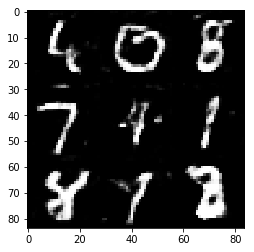

Epoch 1/2 Batch Step 5010... Discriminator Loss: 0.4122... Generator Loss: 4.4827
Epoch 1/2 Batch Step 5020... Discriminator Loss: 0.4809... Generator Loss: 2.6079
Epoch 1/2 Batch Step 5030... Discriminator Loss: 0.8466... Generator Loss: 2.8773
Epoch 1/2 Batch Step 5040... Discriminator Loss: 0.4839... Generator Loss: 2.4893
Epoch 1/2 Batch Step 5050... Discriminator Loss: 0.6469... Generator Loss: 3.5600
Epoch 1/2 Batch Step 5060... Discriminator Loss: 0.9032... Generator Loss: 2.2436
Epoch 1/2 Batch Step 5070... Discriminator Loss: 0.3734... Generator Loss: 2.6858
Epoch 1/2 Batch Step 5080... Discriminator Loss: 0.4079... Generator Loss: 2.9981
Epoch 1/2 Batch Step 5090... Discriminator Loss: 0.6233... Generator Loss: 2.9091
Epoch 1/2 Batch Step 5100... Discriminator Loss: 0.4020... Generator Loss: 2.1356


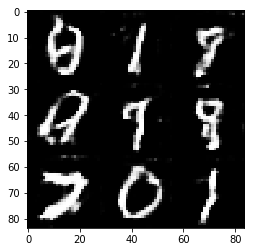

Epoch 1/2 Batch Step 5110... Discriminator Loss: 0.5738... Generator Loss: 4.4102
Epoch 1/2 Batch Step 5120... Discriminator Loss: 0.4118... Generator Loss: 3.1219
Epoch 1/2 Batch Step 5130... Discriminator Loss: 0.6141... Generator Loss: 1.2425
Epoch 1/2 Batch Step 5140... Discriminator Loss: 0.3474... Generator Loss: 5.7678
Epoch 1/2 Batch Step 5150... Discriminator Loss: 0.4641... Generator Loss: 3.5234
Epoch 1/2 Batch Step 5160... Discriminator Loss: 0.4297... Generator Loss: 3.9164
Epoch 1/2 Batch Step 5170... Discriminator Loss: 0.3784... Generator Loss: 4.2040
Epoch 1/2 Batch Step 5180... Discriminator Loss: 0.3723... Generator Loss: 3.2142
Epoch 1/2 Batch Step 5190... Discriminator Loss: 0.3987... Generator Loss: 2.8622
Epoch 1/2 Batch Step 5200... Discriminator Loss: 0.4020... Generator Loss: 2.9250


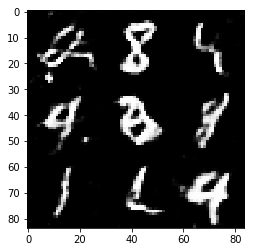

Epoch 1/2 Batch Step 5210... Discriminator Loss: 0.5565... Generator Loss: 4.7198
Epoch 1/2 Batch Step 5220... Discriminator Loss: 0.4768... Generator Loss: 3.0388
Epoch 1/2 Batch Step 5230... Discriminator Loss: 0.5384... Generator Loss: 2.2079
Epoch 1/2 Batch Step 5240... Discriminator Loss: 0.3950... Generator Loss: 4.6387
Epoch 1/2 Batch Step 5250... Discriminator Loss: 0.4988... Generator Loss: 2.9232
Epoch 1/2 Batch Step 5260... Discriminator Loss: 0.4293... Generator Loss: 3.1488
Epoch 1/2 Batch Step 5270... Discriminator Loss: 0.3926... Generator Loss: 3.0915
Epoch 1/2 Batch Step 5280... Discriminator Loss: 0.3740... Generator Loss: 6.4947
Epoch 1/2 Batch Step 5290... Discriminator Loss: 0.5115... Generator Loss: 3.2595
Epoch 1/2 Batch Step 5300... Discriminator Loss: 0.4247... Generator Loss: 4.8611


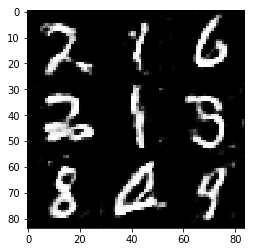

Epoch 1/2 Batch Step 5310... Discriminator Loss: 0.8637... Generator Loss: 1.5861
Epoch 1/2 Batch Step 5320... Discriminator Loss: 0.5685... Generator Loss: 4.3314
Epoch 1/2 Batch Step 5330... Discriminator Loss: 0.5947... Generator Loss: 2.8775
Epoch 1/2 Batch Step 5340... Discriminator Loss: 0.4835... Generator Loss: 2.4308
Epoch 1/2 Batch Step 5350... Discriminator Loss: 0.4482... Generator Loss: 4.3392
Epoch 1/2 Batch Step 5360... Discriminator Loss: 0.4658... Generator Loss: 3.6932
Epoch 1/2 Batch Step 5370... Discriminator Loss: 0.7830... Generator Loss: 1.4732
Epoch 1/2 Batch Step 5380... Discriminator Loss: 0.3970... Generator Loss: 3.7047
Epoch 1/2 Batch Step 5390... Discriminator Loss: 0.4451... Generator Loss: 3.2995
Epoch 1/2 Batch Step 5400... Discriminator Loss: 0.3708... Generator Loss: 3.8958


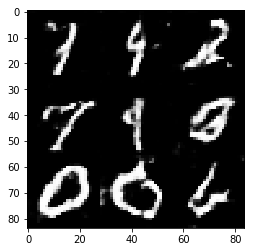

Epoch 1/2 Batch Step 5410... Discriminator Loss: 0.4566... Generator Loss: 3.6552
Epoch 1/2 Batch Step 5420... Discriminator Loss: 0.4806... Generator Loss: 2.2704
Epoch 1/2 Batch Step 5430... Discriminator Loss: 0.5137... Generator Loss: 3.1442
Epoch 1/2 Batch Step 5440... Discriminator Loss: 0.9036... Generator Loss: 1.7850
Epoch 1/2 Batch Step 5450... Discriminator Loss: 0.5795... Generator Loss: 1.4878
Epoch 1/2 Batch Step 5460... Discriminator Loss: 0.4550... Generator Loss: 3.8203
Epoch 1/2 Batch Step 5470... Discriminator Loss: 0.5690... Generator Loss: 3.1054
Epoch 1/2 Batch Step 5480... Discriminator Loss: 0.4144... Generator Loss: 4.3564
Epoch 1/2 Batch Step 5490... Discriminator Loss: 0.3687... Generator Loss: 5.5090
Epoch 1/2 Batch Step 5500... Discriminator Loss: 0.7241... Generator Loss: 1.2442


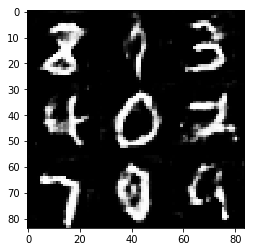

Epoch 1/2 Batch Step 5510... Discriminator Loss: 0.7129... Generator Loss: 2.2779
Epoch 1/2 Batch Step 5520... Discriminator Loss: 0.4276... Generator Loss: 3.2918
Epoch 1/2 Batch Step 5530... Discriminator Loss: 0.4508... Generator Loss: 2.5451
Epoch 1/2 Batch Step 5540... Discriminator Loss: 0.5928... Generator Loss: 2.6512
Epoch 1/2 Batch Step 5550... Discriminator Loss: 0.5924... Generator Loss: 0.9868
Epoch 1/2 Batch Step 5560... Discriminator Loss: 0.3876... Generator Loss: 4.5078
Epoch 1/2 Batch Step 5570... Discriminator Loss: 0.4092... Generator Loss: 4.7499
Epoch 1/2 Batch Step 5580... Discriminator Loss: 0.4041... Generator Loss: 5.7744
Epoch 1/2 Batch Step 5590... Discriminator Loss: 0.3702... Generator Loss: 2.6002
Epoch 1/2 Batch Step 5600... Discriminator Loss: 0.4614... Generator Loss: 4.4089


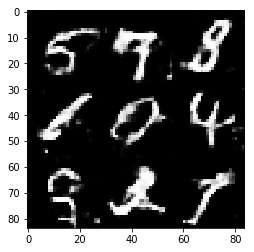

Epoch 1/2 Batch Step 5610... Discriminator Loss: 0.4958... Generator Loss: 4.3791
Epoch 1/2 Batch Step 5620... Discriminator Loss: 0.4011... Generator Loss: 3.7809
Epoch 1/2 Batch Step 5630... Discriminator Loss: 0.3646... Generator Loss: 5.0728
Epoch 1/2 Batch Step 5640... Discriminator Loss: 0.3845... Generator Loss: 4.3159
Epoch 1/2 Batch Step 5650... Discriminator Loss: 0.4321... Generator Loss: 2.1377
Epoch 1/2 Batch Step 5660... Discriminator Loss: 1.0569... Generator Loss: 2.0214
Epoch 1/2 Batch Step 5670... Discriminator Loss: 0.4501... Generator Loss: 3.6311
Epoch 1/2 Batch Step 5680... Discriminator Loss: 0.6079... Generator Loss: 4.6786
Epoch 1/2 Batch Step 5690... Discriminator Loss: 0.4575... Generator Loss: 6.3443
Epoch 1/2 Batch Step 5700... Discriminator Loss: 0.6180... Generator Loss: 0.6724


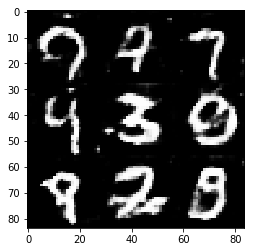

Epoch 1/2 Batch Step 5710... Discriminator Loss: 0.3527... Generator Loss: 4.4055
Epoch 1/2 Batch Step 5720... Discriminator Loss: 0.3658... Generator Loss: 3.4216
Epoch 1/2 Batch Step 5730... Discriminator Loss: 0.4980... Generator Loss: 1.4992
Epoch 1/2 Batch Step 5740... Discriminator Loss: 0.4435... Generator Loss: 3.9911
Epoch 1/2 Batch Step 5750... Discriminator Loss: 0.8536... Generator Loss: 1.2678
Epoch 1/2 Batch Step 5760... Discriminator Loss: 0.5325... Generator Loss: 5.4481
Epoch 1/2 Batch Step 5770... Discriminator Loss: 0.3884... Generator Loss: 5.9102
Epoch 1/2 Batch Step 5780... Discriminator Loss: 0.3897... Generator Loss: 3.4921
Epoch 1/2 Batch Step 5790... Discriminator Loss: 0.3676... Generator Loss: 4.5230
Epoch 1/2 Batch Step 5800... Discriminator Loss: 0.4813... Generator Loss: 2.3497


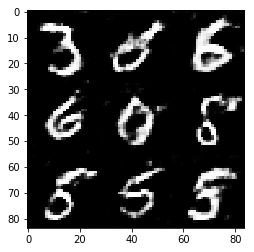

Epoch 1/2 Batch Step 5810... Discriminator Loss: 0.5502... Generator Loss: 2.5401
Epoch 1/2 Batch Step 5820... Discriminator Loss: 0.3776... Generator Loss: 5.4203
Epoch 1/2 Batch Step 5830... Discriminator Loss: 0.3778... Generator Loss: 4.5684
Epoch 1/2 Batch Step 5840... Discriminator Loss: 0.3990... Generator Loss: 4.2063
Epoch 1/2 Batch Step 5850... Discriminator Loss: 0.4751... Generator Loss: 2.6677
Epoch 1/2 Batch Step 5860... Discriminator Loss: 0.4594... Generator Loss: 4.4972
Epoch 1/2 Batch Step 5870... Discriminator Loss: 0.3918... Generator Loss: 4.3394
Epoch 1/2 Batch Step 5880... Discriminator Loss: 0.3980... Generator Loss: 3.6443
Epoch 1/2 Batch Step 5890... Discriminator Loss: 0.4877... Generator Loss: 1.4412
Epoch 1/2 Batch Step 5900... Discriminator Loss: 0.4091... Generator Loss: 4.3088


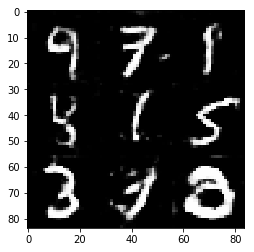

Epoch 1/2 Batch Step 5910... Discriminator Loss: 0.3717... Generator Loss: 3.5784
Epoch 1/2 Batch Step 5920... Discriminator Loss: 0.4521... Generator Loss: 2.1544
Epoch 1/2 Batch Step 5930... Discriminator Loss: 0.6173... Generator Loss: 2.0388
Epoch 1/2 Batch Step 5940... Discriminator Loss: 0.3988... Generator Loss: 3.5973
Epoch 1/2 Batch Step 5950... Discriminator Loss: 0.5054... Generator Loss: 2.9238
Epoch 1/2 Batch Step 5960... Discriminator Loss: 0.4206... Generator Loss: 5.6297
Epoch 1/2 Batch Step 5970... Discriminator Loss: 0.5829... Generator Loss: 4.7981
Epoch 1/2 Batch Step 5980... Discriminator Loss: 0.3889... Generator Loss: 2.9277
Epoch 1/2 Batch Step 5990... Discriminator Loss: 0.4754... Generator Loss: 3.9033
Epoch 1/2 Batch Step 6000... Discriminator Loss: 0.3639... Generator Loss: 4.3419


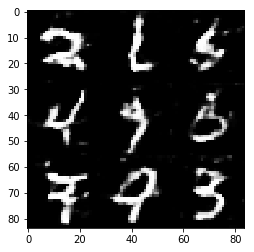

Epoch 1/2 Batch Step 6010... Discriminator Loss: 0.4118... Generator Loss: 3.0532
Epoch 1/2 Batch Step 6020... Discriminator Loss: 0.3699... Generator Loss: 3.6820
Epoch 1/2 Batch Step 6030... Discriminator Loss: 0.4256... Generator Loss: 2.2885
Epoch 1/2 Batch Step 6040... Discriminator Loss: 0.5493... Generator Loss: 2.3366
Epoch 1/2 Batch Step 6050... Discriminator Loss: 0.4662... Generator Loss: 3.5369
Epoch 1/2 Batch Step 6060... Discriminator Loss: 0.5255... Generator Loss: 2.6630
Epoch 1/2 Batch Step 6070... Discriminator Loss: 0.3941... Generator Loss: 2.3503
Epoch 1/2 Batch Step 6080... Discriminator Loss: 0.3758... Generator Loss: 1.8277
Epoch 1/2 Batch Step 6090... Discriminator Loss: 0.4028... Generator Loss: 2.5917
Epoch 1/2 Batch Step 6100... Discriminator Loss: 0.4559... Generator Loss: 1.5491


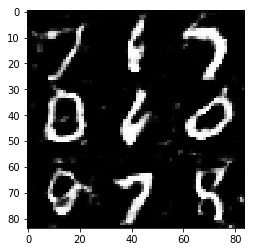

Epoch 1/2 Batch Step 6110... Discriminator Loss: 0.3776... Generator Loss: 2.7204
Epoch 1/2 Batch Step 6120... Discriminator Loss: 0.3999... Generator Loss: 5.1135
Epoch 1/2 Batch Step 6130... Discriminator Loss: 0.4357... Generator Loss: 3.4640
Epoch 1/2 Batch Step 6140... Discriminator Loss: 0.4746... Generator Loss: 2.8348
Epoch 1/2 Batch Step 6150... Discriminator Loss: 0.3458... Generator Loss: 3.6700
Epoch 1/2 Batch Step 6160... Discriminator Loss: 0.4541... Generator Loss: 3.7273
Epoch 1/2 Batch Step 6170... Discriminator Loss: 0.3865... Generator Loss: 3.0427
Epoch 1/2 Batch Step 6180... Discriminator Loss: 0.4382... Generator Loss: 1.7396
Epoch 1/2 Batch Step 6190... Discriminator Loss: 0.5132... Generator Loss: 1.7289
Epoch 1/2 Batch Step 6200... Discriminator Loss: 0.8739... Generator Loss: 1.7424


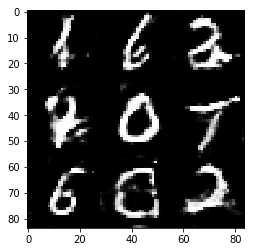

Epoch 1/2 Batch Step 6210... Discriminator Loss: 0.9521... Generator Loss: 1.6694
Epoch 1/2 Batch Step 6220... Discriminator Loss: 0.5235... Generator Loss: 2.7550
Epoch 1/2 Batch Step 6230... Discriminator Loss: 0.3490... Generator Loss: 4.2306
Epoch 1/2 Batch Step 6240... Discriminator Loss: 0.4844... Generator Loss: 3.1580
Epoch 1/2 Batch Step 6250... Discriminator Loss: 0.4626... Generator Loss: 3.7392
Epoch 1/2 Batch Step 6260... Discriminator Loss: 0.3789... Generator Loss: 2.3764
Epoch 1/2 Batch Step 6270... Discriminator Loss: 0.4616... Generator Loss: 2.7595
Epoch 1/2 Batch Step 6280... Discriminator Loss: 0.4305... Generator Loss: 3.7941
Epoch 1/2 Batch Step 6290... Discriminator Loss: 0.5180... Generator Loss: 1.3969
Epoch 1/2 Batch Step 6300... Discriminator Loss: 0.6349... Generator Loss: 1.7170


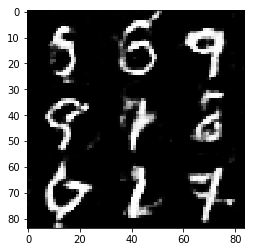

Epoch 1/2 Batch Step 6310... Discriminator Loss: 0.3902... Generator Loss: 4.5678
Epoch 1/2 Batch Step 6320... Discriminator Loss: 0.3678... Generator Loss: 3.9636
Epoch 1/2 Batch Step 6330... Discriminator Loss: 0.6603... Generator Loss: 2.4592
Epoch 1/2 Batch Step 6340... Discriminator Loss: 0.5153... Generator Loss: 2.2973
Epoch 1/2 Batch Step 6350... Discriminator Loss: 0.3782... Generator Loss: 4.2602
Epoch 1/2 Batch Step 6360... Discriminator Loss: 0.7027... Generator Loss: 2.7854
Epoch 1/2 Batch Step 6370... Discriminator Loss: 0.4021... Generator Loss: 2.6911
Epoch 1/2 Batch Step 6380... Discriminator Loss: 0.5720... Generator Loss: 1.9581
Epoch 1/2 Batch Step 6390... Discriminator Loss: 0.7678... Generator Loss: 6.1112
Epoch 1/2 Batch Step 6400... Discriminator Loss: 0.6059... Generator Loss: 2.1574


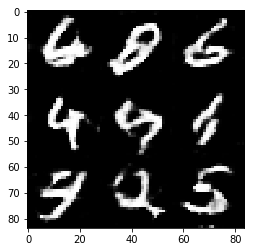

Epoch 1/2 Batch Step 6410... Discriminator Loss: 0.4129... Generator Loss: 3.0358
Epoch 1/2 Batch Step 6420... Discriminator Loss: 0.6597... Generator Loss: 3.6910
Epoch 1/2 Batch Step 6430... Discriminator Loss: 0.4968... Generator Loss: 3.1184
Epoch 1/2 Batch Step 6440... Discriminator Loss: 0.3827... Generator Loss: 2.4835
Epoch 1/2 Batch Step 6450... Discriminator Loss: 0.4672... Generator Loss: 3.1175
Epoch 1/2 Batch Step 6460... Discriminator Loss: 0.4146... Generator Loss: 3.9200
Epoch 1/2 Batch Step 6470... Discriminator Loss: 0.4281... Generator Loss: 2.9485
Epoch 1/2 Batch Step 6480... Discriminator Loss: 0.4875... Generator Loss: 2.1874
Epoch 1/2 Batch Step 6490... Discriminator Loss: 0.3745... Generator Loss: 3.8383
Epoch 1/2 Batch Step 6500... Discriminator Loss: 0.3551... Generator Loss: 2.2417


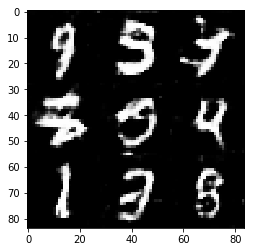

Epoch 1/2 Batch Step 6510... Discriminator Loss: 0.3928... Generator Loss: 2.6446
Epoch 1/2 Batch Step 6520... Discriminator Loss: 0.3884... Generator Loss: 4.3509
Epoch 1/2 Batch Step 6530... Discriminator Loss: 0.4049... Generator Loss: 5.5400
Epoch 1/2 Batch Step 6540... Discriminator Loss: 0.4109... Generator Loss: 3.5853
Epoch 1/2 Batch Step 6550... Discriminator Loss: 0.6453... Generator Loss: 1.6188
Epoch 1/2 Batch Step 6560... Discriminator Loss: 0.4040... Generator Loss: 3.7707
Epoch 1/2 Batch Step 6570... Discriminator Loss: 0.8932... Generator Loss: 1.0244
Epoch 1/2 Batch Step 6580... Discriminator Loss: 0.5515... Generator Loss: 2.6347
Epoch 1/2 Batch Step 6590... Discriminator Loss: 0.4103... Generator Loss: 3.0311
Epoch 1/2 Batch Step 6600... Discriminator Loss: 0.7169... Generator Loss: 0.9815


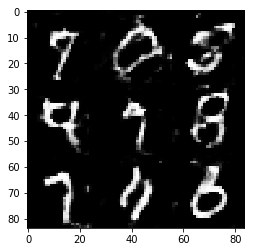

Epoch 1/2 Batch Step 6610... Discriminator Loss: 0.4200... Generator Loss: 2.9491
Epoch 1/2 Batch Step 6620... Discriminator Loss: 0.4910... Generator Loss: 3.1492
Epoch 1/2 Batch Step 6630... Discriminator Loss: 0.4366... Generator Loss: 2.6715
Epoch 1/2 Batch Step 6640... Discriminator Loss: 0.6304... Generator Loss: 3.3751
Epoch 1/2 Batch Step 6650... Discriminator Loss: 0.3690... Generator Loss: 4.5009
Epoch 1/2 Batch Step 6660... Discriminator Loss: 0.4648... Generator Loss: 2.1934
Epoch 1/2 Batch Step 6670... Discriminator Loss: 0.4210... Generator Loss: 3.2694
Epoch 1/2 Batch Step 6680... Discriminator Loss: 0.3946... Generator Loss: 3.3094
Epoch 1/2 Batch Step 6690... Discriminator Loss: 0.3715... Generator Loss: 3.6839
Epoch 1/2 Batch Step 6700... Discriminator Loss: 0.5854... Generator Loss: 2.0713


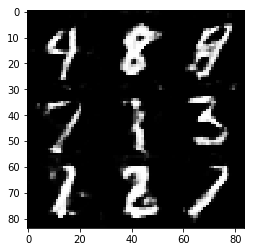

Epoch 1/2 Batch Step 6710... Discriminator Loss: 0.6848... Generator Loss: 3.8453
Epoch 1/2 Batch Step 6720... Discriminator Loss: 1.8801... Generator Loss: 0.6790
Epoch 1/2 Batch Step 6730... Discriminator Loss: 0.4318... Generator Loss: 1.5618
Epoch 1/2 Batch Step 6740... Discriminator Loss: 0.4569... Generator Loss: 1.1371
Epoch 1/2 Batch Step 6750... Discriminator Loss: 0.3607... Generator Loss: 4.2730
Epoch 1/2 Batch Step 6760... Discriminator Loss: 0.3760... Generator Loss: 4.3294
Epoch 1/2 Batch Step 6770... Discriminator Loss: 0.8763... Generator Loss: 4.4040
Epoch 1/2 Batch Step 6780... Discriminator Loss: 0.4152... Generator Loss: 2.8350
Epoch 1/2 Batch Step 6790... Discriminator Loss: 0.3619... Generator Loss: 3.5668
Epoch 1/2 Batch Step 6800... Discriminator Loss: 0.3778... Generator Loss: 4.5373


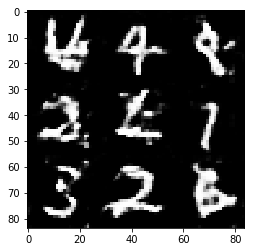

Epoch 1/2 Batch Step 6810... Discriminator Loss: 0.6192... Generator Loss: 3.8827
Epoch 1/2 Batch Step 6820... Discriminator Loss: 0.4931... Generator Loss: 2.0823
Epoch 1/2 Batch Step 6830... Discriminator Loss: 0.3852... Generator Loss: 4.3860
Epoch 1/2 Batch Step 6840... Discriminator Loss: 0.8005... Generator Loss: 4.9500
Epoch 1/2 Batch Step 6850... Discriminator Loss: 0.3812... Generator Loss: 3.7407
Epoch 1/2 Batch Step 6860... Discriminator Loss: 0.4032... Generator Loss: 3.7259
Epoch 1/2 Batch Step 6870... Discriminator Loss: 0.3857... Generator Loss: 4.4292
Epoch 1/2 Batch Step 6880... Discriminator Loss: 0.3760... Generator Loss: 4.0793
Epoch 1/2 Batch Step 6890... Discriminator Loss: 0.3977... Generator Loss: 4.1819
Epoch 1/2 Batch Step 6900... Discriminator Loss: 0.3668... Generator Loss: 2.8792


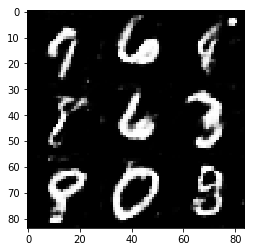

Epoch 1/2 Batch Step 6910... Discriminator Loss: 0.5537... Generator Loss: 1.5068
Epoch 1/2 Batch Step 6920... Discriminator Loss: 0.3647... Generator Loss: 3.2644
Epoch 1/2 Batch Step 6930... Discriminator Loss: 0.3642... Generator Loss: 3.6895
Epoch 1/2 Batch Step 6940... Discriminator Loss: 0.6640... Generator Loss: 1.8067
Epoch 1/2 Batch Step 6950... Discriminator Loss: 0.5750... Generator Loss: 1.6094
Epoch 1/2 Batch Step 6960... Discriminator Loss: 0.4244... Generator Loss: 4.4816
Epoch 1/2 Batch Step 6970... Discriminator Loss: 0.5112... Generator Loss: 3.5940
Epoch 1/2 Batch Step 6980... Discriminator Loss: 0.4270... Generator Loss: 4.7791
Epoch 1/2 Batch Step 6990... Discriminator Loss: 0.5210... Generator Loss: 3.2461
Epoch 1/2 Batch Step 7000... Discriminator Loss: 0.3979... Generator Loss: 1.3341


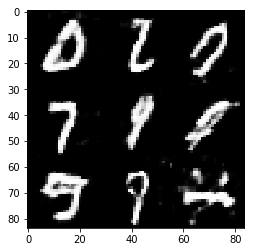

Epoch 1/2 Batch Step 7010... Discriminator Loss: 0.4161... Generator Loss: 4.0672
Epoch 1/2 Batch Step 7020... Discriminator Loss: 0.6860... Generator Loss: 2.2049
Epoch 1/2 Batch Step 7030... Discriminator Loss: 0.3915... Generator Loss: 3.5353
Epoch 1/2 Batch Step 7040... Discriminator Loss: 0.8304... Generator Loss: 5.9776
Epoch 1/2 Batch Step 7050... Discriminator Loss: 0.3851... Generator Loss: 6.7075
Epoch 1/2 Batch Step 7060... Discriminator Loss: 0.4420... Generator Loss: 3.4709
Epoch 1/2 Batch Step 7070... Discriminator Loss: 0.4152... Generator Loss: 2.6348
Epoch 1/2 Batch Step 7080... Discriminator Loss: 0.4964... Generator Loss: 3.1376
Epoch 1/2 Batch Step 7090... Discriminator Loss: 0.3805... Generator Loss: 4.4412
Epoch 1/2 Batch Step 7100... Discriminator Loss: 0.3914... Generator Loss: 4.5249


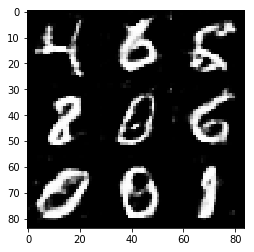

Epoch 1/2 Batch Step 7110... Discriminator Loss: 0.5541... Generator Loss: 3.1239
Epoch 1/2 Batch Step 7120... Discriminator Loss: 0.4334... Generator Loss: 4.0225
Epoch 1/2 Batch Step 7130... Discriminator Loss: 0.4063... Generator Loss: 3.4731
Epoch 1/2 Batch Step 7140... Discriminator Loss: 0.4325... Generator Loss: 5.6656
Epoch 1/2 Batch Step 7150... Discriminator Loss: 0.3814... Generator Loss: 4.8322
Epoch 1/2 Batch Step 7160... Discriminator Loss: 0.4438... Generator Loss: 4.9871
Epoch 1/2 Batch Step 7170... Discriminator Loss: 0.4167... Generator Loss: 1.7096
Epoch 1/2 Batch Step 7180... Discriminator Loss: 0.8517... Generator Loss: 4.1152
Epoch 1/2 Batch Step 7190... Discriminator Loss: 0.3975... Generator Loss: 4.5848
Epoch 1/2 Batch Step 7200... Discriminator Loss: 0.3658... Generator Loss: 4.4810


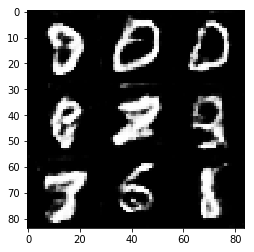

Epoch 1/2 Batch Step 7210... Discriminator Loss: 0.4645... Generator Loss: 5.0719
Epoch 1/2 Batch Step 7220... Discriminator Loss: 0.4028... Generator Loss: 2.4683
Epoch 1/2 Batch Step 7230... Discriminator Loss: 0.5174... Generator Loss: 3.5938
Epoch 1/2 Batch Step 7240... Discriminator Loss: 0.4189... Generator Loss: 3.0688
Epoch 1/2 Batch Step 7250... Discriminator Loss: 0.4542... Generator Loss: 3.1196
Epoch 1/2 Batch Step 7260... Discriminator Loss: 0.4735... Generator Loss: 2.2639
Epoch 1/2 Batch Step 7270... Discriminator Loss: 0.3907... Generator Loss: 4.3214
Epoch 1/2 Batch Step 7280... Discriminator Loss: 0.4958... Generator Loss: 1.5800
Epoch 1/2 Batch Step 7290... Discriminator Loss: 0.4000... Generator Loss: 6.4169
Epoch 1/2 Batch Step 7300... Discriminator Loss: 0.5870... Generator Loss: 2.8849


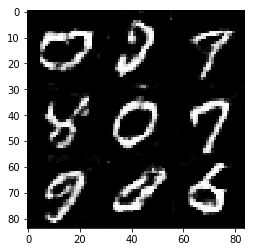

Epoch 1/2 Batch Step 7310... Discriminator Loss: 0.4106... Generator Loss: 2.9060
Epoch 1/2 Batch Step 7320... Discriminator Loss: 0.6229... Generator Loss: 5.1152
Epoch 1/2 Batch Step 7330... Discriminator Loss: 0.3780... Generator Loss: 3.9397
Epoch 1/2 Batch Step 7340... Discriminator Loss: 0.4187... Generator Loss: 3.5999
Epoch 1/2 Batch Step 7350... Discriminator Loss: 0.5666... Generator Loss: 4.6656
Epoch 1/2 Batch Step 7360... Discriminator Loss: 0.6404... Generator Loss: 0.6735
Epoch 1/2 Batch Step 7370... Discriminator Loss: 0.4643... Generator Loss: 2.0587
Epoch 1/2 Batch Step 7380... Discriminator Loss: 0.3489... Generator Loss: 5.3187
Epoch 1/2 Batch Step 7390... Discriminator Loss: 0.4698... Generator Loss: 2.1562
Epoch 1/2 Batch Step 7400... Discriminator Loss: 0.4321... Generator Loss: 3.3843


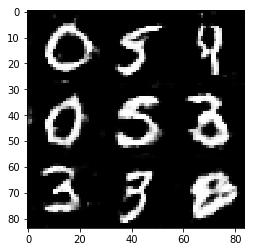

Epoch 1/2 Batch Step 7410... Discriminator Loss: 0.4148... Generator Loss: 3.9370
Epoch 1/2 Batch Step 7420... Discriminator Loss: 0.5908... Generator Loss: 3.7049
Epoch 1/2 Batch Step 7430... Discriminator Loss: 0.4571... Generator Loss: 5.2578
Epoch 1/2 Batch Step 7440... Discriminator Loss: 0.4134... Generator Loss: 4.5045
Epoch 1/2 Batch Step 7450... Discriminator Loss: 0.8366... Generator Loss: 5.8569
Epoch 1/2 Batch Step 7460... Discriminator Loss: 0.3700... Generator Loss: 3.7858
Epoch 1/2 Batch Step 7470... Discriminator Loss: 0.4859... Generator Loss: 4.4740
Epoch 1/2 Batch Step 7480... Discriminator Loss: 0.3623... Generator Loss: 4.2055
Epoch 1/2 Batch Step 7490... Discriminator Loss: 0.5410... Generator Loss: 2.0025
Epoch 1/2 Batch Step 7500... Discriminator Loss: 0.3512... Generator Loss: 5.9569


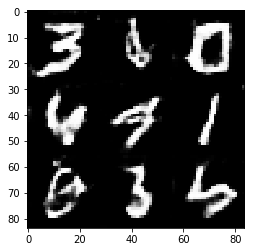

Done Training!


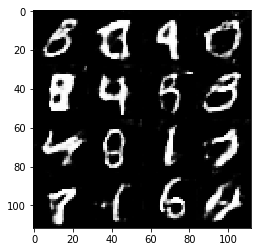

In [27]:
batch_size = 16
z_dim = 100
learning_rate = 0.0002
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1 Batch Step 10... Discriminator Loss: 2.6815... Generator Loss: 7.3651
Epoch 0/1 Batch Step 20... Discriminator Loss: 1.0161... Generator Loss: 4.5167
Epoch 0/1 Batch Step 30... Discriminator Loss: 0.6304... Generator Loss: 3.2639
Epoch 0/1 Batch Step 40... Discriminator Loss: 1.1161... Generator Loss: 1.1531
Epoch 0/1 Batch Step 50... Discriminator Loss: 0.5599... Generator Loss: 4.7412
Epoch 0/1 Batch Step 60... Discriminator Loss: 0.7813... Generator Loss: 1.5362
Epoch 0/1 Batch Step 70... Discriminator Loss: 1.9600... Generator Loss: 0.3383
Epoch 0/1 Batch Step 80... Discriminator Loss: 0.6644... Generator Loss: 2.3367
Epoch 0/1 Batch Step 90... Discriminator Loss: 0.4848... Generator Loss: 3.8337
Epoch 0/1 Batch Step 100... Discriminator Loss: 0.5152... Generator Loss: 3.1786


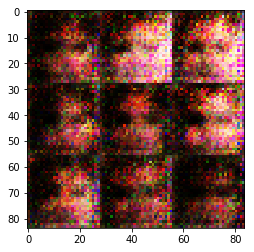

Epoch 0/1 Batch Step 110... Discriminator Loss: 0.4609... Generator Loss: 2.5380
Epoch 0/1 Batch Step 120... Discriminator Loss: 0.4995... Generator Loss: 2.8092
Epoch 0/1 Batch Step 130... Discriminator Loss: 0.6109... Generator Loss: 2.7249
Epoch 0/1 Batch Step 140... Discriminator Loss: 0.3997... Generator Loss: 4.7935
Epoch 0/1 Batch Step 150... Discriminator Loss: 0.4172... Generator Loss: 3.2678
Epoch 0/1 Batch Step 160... Discriminator Loss: 0.5892... Generator Loss: 2.0993
Epoch 0/1 Batch Step 170... Discriminator Loss: 0.9096... Generator Loss: 2.2669
Epoch 0/1 Batch Step 180... Discriminator Loss: 0.8659... Generator Loss: 3.7611
Epoch 0/1 Batch Step 190... Discriminator Loss: 0.6574... Generator Loss: 1.9515
Epoch 0/1 Batch Step 200... Discriminator Loss: 0.7781... Generator Loss: 1.3520


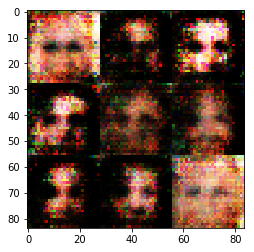

Epoch 0/1 Batch Step 210... Discriminator Loss: 1.1020... Generator Loss: 1.3601
Epoch 0/1 Batch Step 220... Discriminator Loss: 0.6701... Generator Loss: 1.5857
Epoch 0/1 Batch Step 230... Discriminator Loss: 0.8527... Generator Loss: 1.4191
Epoch 0/1 Batch Step 240... Discriminator Loss: 1.1588... Generator Loss: 0.8239
Epoch 0/1 Batch Step 250... Discriminator Loss: 1.0321... Generator Loss: 1.0096
Epoch 0/1 Batch Step 260... Discriminator Loss: 0.8010... Generator Loss: 3.6398
Epoch 0/1 Batch Step 270... Discriminator Loss: 1.4566... Generator Loss: 3.5826
Epoch 0/1 Batch Step 280... Discriminator Loss: 0.8828... Generator Loss: 2.1439
Epoch 0/1 Batch Step 290... Discriminator Loss: 0.5922... Generator Loss: 2.3558
Epoch 0/1 Batch Step 300... Discriminator Loss: 1.0729... Generator Loss: 1.8360


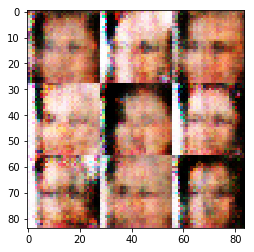

Epoch 0/1 Batch Step 310... Discriminator Loss: 0.6677... Generator Loss: 2.1168
Epoch 0/1 Batch Step 320... Discriminator Loss: 0.6870... Generator Loss: 3.0821
Epoch 0/1 Batch Step 330... Discriminator Loss: 1.2938... Generator Loss: 1.0329
Epoch 0/1 Batch Step 340... Discriminator Loss: 1.1346... Generator Loss: 2.6986
Epoch 0/1 Batch Step 350... Discriminator Loss: 1.0625... Generator Loss: 1.0361
Epoch 0/1 Batch Step 360... Discriminator Loss: 1.0540... Generator Loss: 0.7231
Epoch 0/1 Batch Step 370... Discriminator Loss: 0.8942... Generator Loss: 1.8094
Epoch 0/1 Batch Step 380... Discriminator Loss: 0.8805... Generator Loss: 1.2846
Epoch 0/1 Batch Step 390... Discriminator Loss: 0.8712... Generator Loss: 1.4999
Epoch 0/1 Batch Step 400... Discriminator Loss: 1.0013... Generator Loss: 1.8805


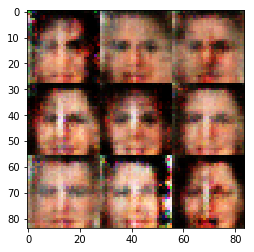

Epoch 0/1 Batch Step 410... Discriminator Loss: 1.9381... Generator Loss: 0.4533
Epoch 0/1 Batch Step 420... Discriminator Loss: 1.4019... Generator Loss: 0.7766
Epoch 0/1 Batch Step 430... Discriminator Loss: 1.5980... Generator Loss: 0.7581
Epoch 0/1 Batch Step 440... Discriminator Loss: 1.3111... Generator Loss: 1.3939
Epoch 0/1 Batch Step 450... Discriminator Loss: 1.1043... Generator Loss: 2.7253
Epoch 0/1 Batch Step 460... Discriminator Loss: 1.3981... Generator Loss: 1.3128
Epoch 0/1 Batch Step 470... Discriminator Loss: 1.1823... Generator Loss: 1.1433
Epoch 0/1 Batch Step 480... Discriminator Loss: 1.5968... Generator Loss: 0.4734
Epoch 0/1 Batch Step 490... Discriminator Loss: 1.2807... Generator Loss: 0.7227
Epoch 0/1 Batch Step 500... Discriminator Loss: 1.3747... Generator Loss: 0.7386


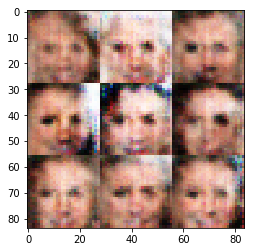

Epoch 0/1 Batch Step 510... Discriminator Loss: 0.9682... Generator Loss: 1.3255
Epoch 0/1 Batch Step 520... Discriminator Loss: 1.2649... Generator Loss: 0.9959
Epoch 0/1 Batch Step 530... Discriminator Loss: 1.4776... Generator Loss: 0.7267
Epoch 0/1 Batch Step 540... Discriminator Loss: 1.3286... Generator Loss: 1.1209
Epoch 0/1 Batch Step 550... Discriminator Loss: 1.3277... Generator Loss: 1.0238
Epoch 0/1 Batch Step 560... Discriminator Loss: 0.9731... Generator Loss: 1.2037
Epoch 0/1 Batch Step 570... Discriminator Loss: 1.1973... Generator Loss: 1.0556
Epoch 0/1 Batch Step 580... Discriminator Loss: 1.3201... Generator Loss: 0.9021
Epoch 0/1 Batch Step 590... Discriminator Loss: 0.7628... Generator Loss: 1.2768
Epoch 0/1 Batch Step 600... Discriminator Loss: 1.0218... Generator Loss: 1.3759


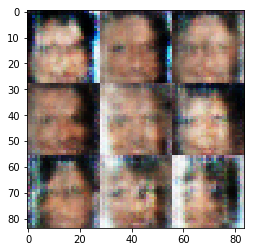

Epoch 0/1 Batch Step 610... Discriminator Loss: 1.2002... Generator Loss: 0.9437
Epoch 0/1 Batch Step 620... Discriminator Loss: 1.0507... Generator Loss: 1.1967
Epoch 0/1 Batch Step 630... Discriminator Loss: 0.9494... Generator Loss: 1.3432
Epoch 0/1 Batch Step 640... Discriminator Loss: 1.0508... Generator Loss: 1.2502
Epoch 0/1 Batch Step 650... Discriminator Loss: 1.0164... Generator Loss: 1.4799
Epoch 0/1 Batch Step 660... Discriminator Loss: 1.2446... Generator Loss: 0.7701
Epoch 0/1 Batch Step 670... Discriminator Loss: 1.2352... Generator Loss: 0.6208
Epoch 0/1 Batch Step 680... Discriminator Loss: 1.0516... Generator Loss: 1.1441
Epoch 0/1 Batch Step 690... Discriminator Loss: 1.2087... Generator Loss: 0.9191
Epoch 0/1 Batch Step 700... Discriminator Loss: 1.1068... Generator Loss: 1.5857


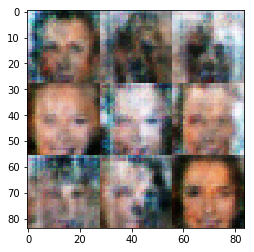

Epoch 0/1 Batch Step 710... Discriminator Loss: 1.0014... Generator Loss: 1.3714
Epoch 0/1 Batch Step 720... Discriminator Loss: 1.0100... Generator Loss: 0.9682
Epoch 0/1 Batch Step 730... Discriminator Loss: 1.0480... Generator Loss: 1.4987
Epoch 0/1 Batch Step 740... Discriminator Loss: 1.4097... Generator Loss: 0.7691
Epoch 0/1 Batch Step 750... Discriminator Loss: 1.0761... Generator Loss: 1.1478
Epoch 0/1 Batch Step 760... Discriminator Loss: 0.7317... Generator Loss: 1.3507
Epoch 0/1 Batch Step 770... Discriminator Loss: 0.9466... Generator Loss: 2.1801
Epoch 0/1 Batch Step 780... Discriminator Loss: 1.2471... Generator Loss: 1.0583
Epoch 0/1 Batch Step 790... Discriminator Loss: 1.0179... Generator Loss: 0.9498
Epoch 0/1 Batch Step 800... Discriminator Loss: 1.0321... Generator Loss: 1.4189


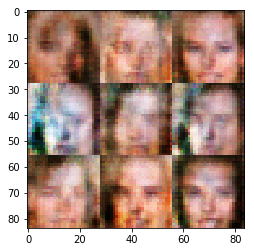

Epoch 0/1 Batch Step 810... Discriminator Loss: 0.8232... Generator Loss: 1.4743
Epoch 0/1 Batch Step 820... Discriminator Loss: 0.9804... Generator Loss: 1.0748
Epoch 0/1 Batch Step 830... Discriminator Loss: 0.9884... Generator Loss: 1.5287
Epoch 0/1 Batch Step 840... Discriminator Loss: 1.1776... Generator Loss: 1.2663
Epoch 0/1 Batch Step 850... Discriminator Loss: 1.3505... Generator Loss: 1.0304
Epoch 0/1 Batch Step 860... Discriminator Loss: 1.1196... Generator Loss: 1.0968
Epoch 0/1 Batch Step 870... Discriminator Loss: 0.9302... Generator Loss: 1.7936
Epoch 0/1 Batch Step 880... Discriminator Loss: 1.0699... Generator Loss: 1.7947
Epoch 0/1 Batch Step 890... Discriminator Loss: 0.9727... Generator Loss: 1.1242
Epoch 0/1 Batch Step 900... Discriminator Loss: 1.2397... Generator Loss: 1.2889


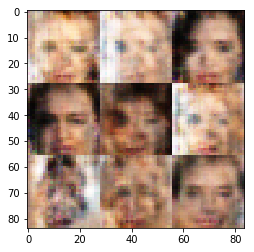

Epoch 0/1 Batch Step 910... Discriminator Loss: 1.0086... Generator Loss: 1.3454
Epoch 0/1 Batch Step 920... Discriminator Loss: 1.1053... Generator Loss: 1.1209
Epoch 0/1 Batch Step 930... Discriminator Loss: 1.1235... Generator Loss: 0.8260
Epoch 0/1 Batch Step 940... Discriminator Loss: 0.9744... Generator Loss: 1.3659
Epoch 0/1 Batch Step 950... Discriminator Loss: 0.8319... Generator Loss: 1.5975
Epoch 0/1 Batch Step 960... Discriminator Loss: 1.0631... Generator Loss: 1.2477
Epoch 0/1 Batch Step 970... Discriminator Loss: 1.1814... Generator Loss: 0.7203
Epoch 0/1 Batch Step 980... Discriminator Loss: 0.9621... Generator Loss: 1.1292
Epoch 0/1 Batch Step 990... Discriminator Loss: 1.1002... Generator Loss: 1.0291
Epoch 0/1 Batch Step 1000... Discriminator Loss: 0.9604... Generator Loss: 1.3722


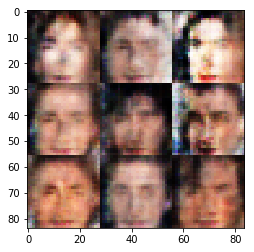

Epoch 0/1 Batch Step 1010... Discriminator Loss: 0.9201... Generator Loss: 1.3147
Epoch 0/1 Batch Step 1020... Discriminator Loss: 0.7525... Generator Loss: 1.7054
Epoch 0/1 Batch Step 1030... Discriminator Loss: 1.0672... Generator Loss: 1.5643
Epoch 0/1 Batch Step 1040... Discriminator Loss: 1.0294... Generator Loss: 1.1672
Epoch 0/1 Batch Step 1050... Discriminator Loss: 0.8101... Generator Loss: 1.4771
Epoch 0/1 Batch Step 1060... Discriminator Loss: 1.0453... Generator Loss: 0.8247
Epoch 0/1 Batch Step 1070... Discriminator Loss: 1.2543... Generator Loss: 0.6343
Epoch 0/1 Batch Step 1080... Discriminator Loss: 1.2321... Generator Loss: 0.8194
Epoch 0/1 Batch Step 1090... Discriminator Loss: 0.7833... Generator Loss: 1.9580
Epoch 0/1 Batch Step 1100... Discriminator Loss: 1.0063... Generator Loss: 1.0382


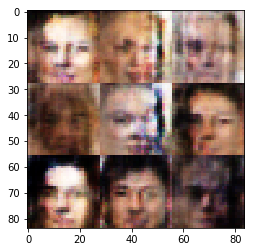

Epoch 0/1 Batch Step 1110... Discriminator Loss: 0.8651... Generator Loss: 0.9436
Epoch 0/1 Batch Step 1120... Discriminator Loss: 1.0495... Generator Loss: 1.1632
Epoch 0/1 Batch Step 1130... Discriminator Loss: 1.0437... Generator Loss: 1.1464
Epoch 0/1 Batch Step 1140... Discriminator Loss: 0.8627... Generator Loss: 1.3100
Epoch 0/1 Batch Step 1150... Discriminator Loss: 1.1143... Generator Loss: 2.0706
Epoch 0/1 Batch Step 1160... Discriminator Loss: 0.9035... Generator Loss: 1.4893
Epoch 0/1 Batch Step 1170... Discriminator Loss: 0.9558... Generator Loss: 1.3665
Epoch 0/1 Batch Step 1180... Discriminator Loss: 0.7882... Generator Loss: 1.8296
Epoch 0/1 Batch Step 1190... Discriminator Loss: 1.1284... Generator Loss: 1.0101
Epoch 0/1 Batch Step 1200... Discriminator Loss: 1.3919... Generator Loss: 0.4329


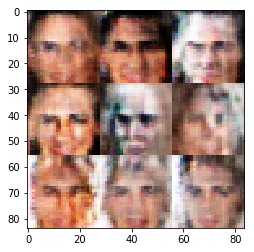

Epoch 0/1 Batch Step 1210... Discriminator Loss: 0.9567... Generator Loss: 1.7862
Epoch 0/1 Batch Step 1220... Discriminator Loss: 1.0907... Generator Loss: 0.8513
Epoch 0/1 Batch Step 1230... Discriminator Loss: 1.3019... Generator Loss: 2.2994
Epoch 0/1 Batch Step 1240... Discriminator Loss: 1.1010... Generator Loss: 1.1391
Epoch 0/1 Batch Step 1250... Discriminator Loss: 0.9585... Generator Loss: 1.1540
Epoch 0/1 Batch Step 1260... Discriminator Loss: 1.1135... Generator Loss: 1.1896
Epoch 0/1 Batch Step 1270... Discriminator Loss: 1.1598... Generator Loss: 2.4401
Epoch 0/1 Batch Step 1280... Discriminator Loss: 0.9127... Generator Loss: 2.0174
Epoch 0/1 Batch Step 1290... Discriminator Loss: 1.0369... Generator Loss: 1.0937
Epoch 0/1 Batch Step 1300... Discriminator Loss: 1.0730... Generator Loss: 1.3998


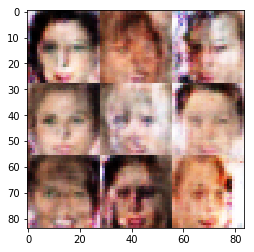

Epoch 0/1 Batch Step 1310... Discriminator Loss: 0.7938... Generator Loss: 1.3669
Epoch 0/1 Batch Step 1320... Discriminator Loss: 0.9937... Generator Loss: 1.1720
Epoch 0/1 Batch Step 1330... Discriminator Loss: 1.2407... Generator Loss: 1.3512
Epoch 0/1 Batch Step 1340... Discriminator Loss: 0.9087... Generator Loss: 2.1545
Epoch 0/1 Batch Step 1350... Discriminator Loss: 0.8073... Generator Loss: 1.3982
Epoch 0/1 Batch Step 1360... Discriminator Loss: 1.1174... Generator Loss: 1.2301
Epoch 0/1 Batch Step 1370... Discriminator Loss: 0.9091... Generator Loss: 1.6408
Epoch 0/1 Batch Step 1380... Discriminator Loss: 1.0014... Generator Loss: 1.0741
Epoch 0/1 Batch Step 1390... Discriminator Loss: 1.0562... Generator Loss: 0.8153
Epoch 0/1 Batch Step 1400... Discriminator Loss: 1.3242... Generator Loss: 0.5086


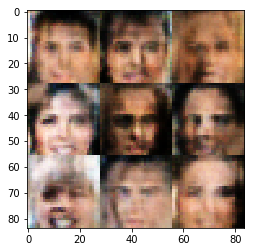

Epoch 0/1 Batch Step 1410... Discriminator Loss: 1.0010... Generator Loss: 1.1806
Epoch 0/1 Batch Step 1420... Discriminator Loss: 0.9249... Generator Loss: 1.7465
Epoch 0/1 Batch Step 1430... Discriminator Loss: 1.7366... Generator Loss: 1.9166
Epoch 0/1 Batch Step 1440... Discriminator Loss: 1.1838... Generator Loss: 1.9224
Epoch 0/1 Batch Step 1450... Discriminator Loss: 1.0415... Generator Loss: 1.1850
Epoch 0/1 Batch Step 1460... Discriminator Loss: 1.0907... Generator Loss: 1.7154
Epoch 0/1 Batch Step 1470... Discriminator Loss: 0.8274... Generator Loss: 1.2798
Epoch 0/1 Batch Step 1480... Discriminator Loss: 0.9173... Generator Loss: 1.0394
Epoch 0/1 Batch Step 1490... Discriminator Loss: 0.7616... Generator Loss: 1.3174
Epoch 0/1 Batch Step 1500... Discriminator Loss: 0.9850... Generator Loss: 1.1450


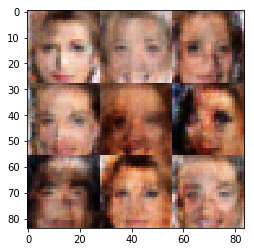

Epoch 0/1 Batch Step 1510... Discriminator Loss: 0.8809... Generator Loss: 1.0679
Epoch 0/1 Batch Step 1520... Discriminator Loss: 0.9565... Generator Loss: 1.0265
Epoch 0/1 Batch Step 1530... Discriminator Loss: 1.2519... Generator Loss: 2.4584
Epoch 0/1 Batch Step 1540... Discriminator Loss: 1.0676... Generator Loss: 1.0891
Epoch 0/1 Batch Step 1550... Discriminator Loss: 0.9472... Generator Loss: 1.2631
Epoch 0/1 Batch Step 1560... Discriminator Loss: 1.1117... Generator Loss: 1.4425
Epoch 0/1 Batch Step 1570... Discriminator Loss: 0.9429... Generator Loss: 1.2820
Epoch 0/1 Batch Step 1580... Discriminator Loss: 1.2693... Generator Loss: 0.7461
Epoch 0/1 Batch Step 1590... Discriminator Loss: 1.4360... Generator Loss: 0.5880
Epoch 0/1 Batch Step 1600... Discriminator Loss: 1.1134... Generator Loss: 1.0006


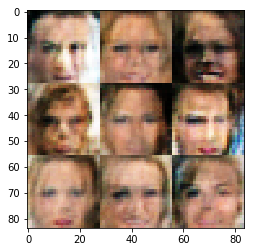

Epoch 0/1 Batch Step 1610... Discriminator Loss: 0.9656... Generator Loss: 1.4880
Epoch 0/1 Batch Step 1620... Discriminator Loss: 0.9073... Generator Loss: 1.4783
Epoch 0/1 Batch Step 1630... Discriminator Loss: 1.1110... Generator Loss: 1.0965
Epoch 0/1 Batch Step 1640... Discriminator Loss: 0.8882... Generator Loss: 1.2514
Epoch 0/1 Batch Step 1650... Discriminator Loss: 1.5351... Generator Loss: 0.6401
Epoch 0/1 Batch Step 1660... Discriminator Loss: 1.0366... Generator Loss: 1.5339
Epoch 0/1 Batch Step 1670... Discriminator Loss: 1.0782... Generator Loss: 1.0156
Epoch 0/1 Batch Step 1680... Discriminator Loss: 0.8842... Generator Loss: 1.3105
Epoch 0/1 Batch Step 1690... Discriminator Loss: 1.0238... Generator Loss: 1.5971
Epoch 0/1 Batch Step 1700... Discriminator Loss: 1.0791... Generator Loss: 0.9430


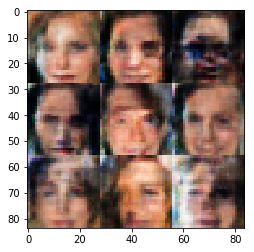

Epoch 0/1 Batch Step 1710... Discriminator Loss: 0.7683... Generator Loss: 1.7209
Epoch 0/1 Batch Step 1720... Discriminator Loss: 1.0691... Generator Loss: 1.1430
Epoch 0/1 Batch Step 1730... Discriminator Loss: 1.1354... Generator Loss: 0.9708
Epoch 0/1 Batch Step 1740... Discriminator Loss: 1.0473... Generator Loss: 0.8600
Epoch 0/1 Batch Step 1750... Discriminator Loss: 1.0895... Generator Loss: 1.3073
Epoch 0/1 Batch Step 1760... Discriminator Loss: 0.7843... Generator Loss: 1.2045
Epoch 0/1 Batch Step 1770... Discriminator Loss: 0.7797... Generator Loss: 1.3449
Epoch 0/1 Batch Step 1780... Discriminator Loss: 0.9703... Generator Loss: 0.8589
Epoch 0/1 Batch Step 1790... Discriminator Loss: 0.9495... Generator Loss: 1.0981
Epoch 0/1 Batch Step 1800... Discriminator Loss: 0.9102... Generator Loss: 1.0702


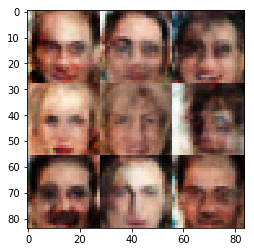

Epoch 0/1 Batch Step 1810... Discriminator Loss: 1.0862... Generator Loss: 1.4220
Epoch 0/1 Batch Step 1820... Discriminator Loss: 1.1600... Generator Loss: 1.4040
Epoch 0/1 Batch Step 1830... Discriminator Loss: 1.1742... Generator Loss: 1.0110
Epoch 0/1 Batch Step 1840... Discriminator Loss: 1.0094... Generator Loss: 0.8844
Epoch 0/1 Batch Step 1850... Discriminator Loss: 0.9024... Generator Loss: 1.1513
Epoch 0/1 Batch Step 1860... Discriminator Loss: 0.9445... Generator Loss: 2.1491
Epoch 0/1 Batch Step 1870... Discriminator Loss: 1.3770... Generator Loss: 2.0740
Epoch 0/1 Batch Step 1880... Discriminator Loss: 1.3508... Generator Loss: 1.7517
Epoch 0/1 Batch Step 1890... Discriminator Loss: 0.8700... Generator Loss: 2.3157
Epoch 0/1 Batch Step 1900... Discriminator Loss: 1.1233... Generator Loss: 1.4150


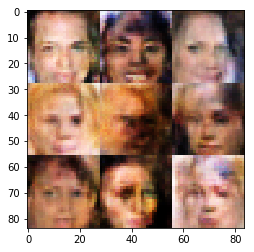

Epoch 0/1 Batch Step 1910... Discriminator Loss: 0.8585... Generator Loss: 1.4335
Epoch 0/1 Batch Step 1920... Discriminator Loss: 1.0807... Generator Loss: 0.7819
Epoch 0/1 Batch Step 1930... Discriminator Loss: 0.7974... Generator Loss: 1.7138
Epoch 0/1 Batch Step 1940... Discriminator Loss: 1.1075... Generator Loss: 1.7798
Epoch 0/1 Batch Step 1950... Discriminator Loss: 0.9003... Generator Loss: 1.1887
Epoch 0/1 Batch Step 1960... Discriminator Loss: 0.8721... Generator Loss: 1.2642
Epoch 0/1 Batch Step 1970... Discriminator Loss: 0.8618... Generator Loss: 1.7852
Epoch 0/1 Batch Step 1980... Discriminator Loss: 0.8947... Generator Loss: 1.3611
Epoch 0/1 Batch Step 1990... Discriminator Loss: 0.9713... Generator Loss: 1.1458
Epoch 0/1 Batch Step 2000... Discriminator Loss: 1.0034... Generator Loss: 1.5003


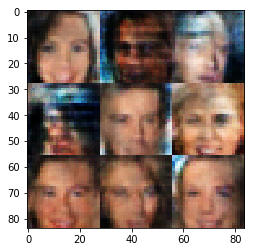

Epoch 0/1 Batch Step 2010... Discriminator Loss: 1.0613... Generator Loss: 1.0875
Epoch 0/1 Batch Step 2020... Discriminator Loss: 0.9267... Generator Loss: 1.7515
Epoch 0/1 Batch Step 2030... Discriminator Loss: 1.1326... Generator Loss: 1.1202
Epoch 0/1 Batch Step 2040... Discriminator Loss: 0.8376... Generator Loss: 1.5893
Epoch 0/1 Batch Step 2050... Discriminator Loss: 0.9660... Generator Loss: 1.6447
Epoch 0/1 Batch Step 2060... Discriminator Loss: 1.1902... Generator Loss: 0.6639
Epoch 0/1 Batch Step 2070... Discriminator Loss: 0.6710... Generator Loss: 1.6096
Epoch 0/1 Batch Step 2080... Discriminator Loss: 0.8363... Generator Loss: 1.3895
Epoch 0/1 Batch Step 2090... Discriminator Loss: 1.3229... Generator Loss: 0.5431
Epoch 0/1 Batch Step 2100... Discriminator Loss: 1.4576... Generator Loss: 2.1592


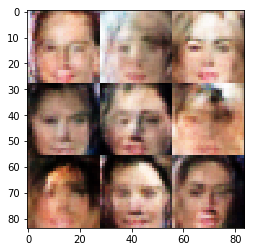

Epoch 0/1 Batch Step 2110... Discriminator Loss: 1.0323... Generator Loss: 1.8477
Epoch 0/1 Batch Step 2120... Discriminator Loss: 1.4851... Generator Loss: 0.3921
Epoch 0/1 Batch Step 2130... Discriminator Loss: 0.8030... Generator Loss: 1.0750
Epoch 0/1 Batch Step 2140... Discriminator Loss: 0.8655... Generator Loss: 1.6457
Epoch 0/1 Batch Step 2150... Discriminator Loss: 0.8378... Generator Loss: 1.0596
Epoch 0/1 Batch Step 2160... Discriminator Loss: 1.0266... Generator Loss: 2.3525
Epoch 0/1 Batch Step 2170... Discriminator Loss: 1.0224... Generator Loss: 1.0014
Epoch 0/1 Batch Step 2180... Discriminator Loss: 1.4959... Generator Loss: 3.0327
Epoch 0/1 Batch Step 2190... Discriminator Loss: 0.8861... Generator Loss: 1.8082
Epoch 0/1 Batch Step 2200... Discriminator Loss: 1.4671... Generator Loss: 0.5137


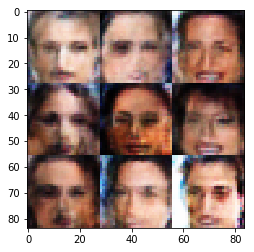

Epoch 0/1 Batch Step 2210... Discriminator Loss: 0.9088... Generator Loss: 1.4860
Epoch 0/1 Batch Step 2220... Discriminator Loss: 1.0960... Generator Loss: 1.5923
Epoch 0/1 Batch Step 2230... Discriminator Loss: 0.6495... Generator Loss: 1.6540
Epoch 0/1 Batch Step 2240... Discriminator Loss: 0.8259... Generator Loss: 2.1094
Epoch 0/1 Batch Step 2250... Discriminator Loss: 0.9811... Generator Loss: 1.0515
Epoch 0/1 Batch Step 2260... Discriminator Loss: 1.1461... Generator Loss: 1.0627
Epoch 0/1 Batch Step 2270... Discriminator Loss: 0.8181... Generator Loss: 2.5695
Epoch 0/1 Batch Step 2280... Discriminator Loss: 0.8839... Generator Loss: 1.1754
Epoch 0/1 Batch Step 2290... Discriminator Loss: 0.7486... Generator Loss: 2.1217
Epoch 0/1 Batch Step 2300... Discriminator Loss: 0.8107... Generator Loss: 1.6156


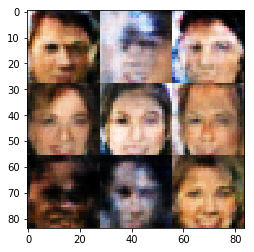

Epoch 0/1 Batch Step 2310... Discriminator Loss: 0.8253... Generator Loss: 1.6909
Epoch 0/1 Batch Step 2320... Discriminator Loss: 0.7116... Generator Loss: 1.3414
Epoch 0/1 Batch Step 2330... Discriminator Loss: 1.2038... Generator Loss: 2.7669
Epoch 0/1 Batch Step 2340... Discriminator Loss: 1.0638... Generator Loss: 1.4374
Epoch 0/1 Batch Step 2350... Discriminator Loss: 0.8913... Generator Loss: 1.5478
Epoch 0/1 Batch Step 2360... Discriminator Loss: 1.0640... Generator Loss: 1.4613
Epoch 0/1 Batch Step 2370... Discriminator Loss: 0.6450... Generator Loss: 1.5469
Epoch 0/1 Batch Step 2380... Discriminator Loss: 0.8581... Generator Loss: 1.5092
Epoch 0/1 Batch Step 2390... Discriminator Loss: 0.8934... Generator Loss: 1.1897
Epoch 0/1 Batch Step 2400... Discriminator Loss: 0.8725... Generator Loss: 1.2718


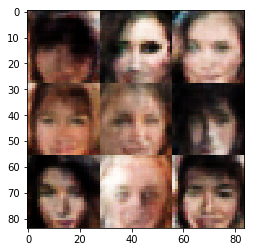

Epoch 0/1 Batch Step 2410... Discriminator Loss: 0.9448... Generator Loss: 0.8795
Epoch 0/1 Batch Step 2420... Discriminator Loss: 0.6736... Generator Loss: 1.1380
Epoch 0/1 Batch Step 2430... Discriminator Loss: 0.7265... Generator Loss: 1.5508
Epoch 0/1 Batch Step 2440... Discriminator Loss: 0.7340... Generator Loss: 1.2558
Epoch 0/1 Batch Step 2450... Discriminator Loss: 0.9618... Generator Loss: 1.0502
Epoch 0/1 Batch Step 2460... Discriminator Loss: 0.8222... Generator Loss: 1.1354
Epoch 0/1 Batch Step 2470... Discriminator Loss: 0.7615... Generator Loss: 1.4330
Epoch 0/1 Batch Step 2480... Discriminator Loss: 0.8668... Generator Loss: 1.6350
Epoch 0/1 Batch Step 2490... Discriminator Loss: 0.8600... Generator Loss: 1.2628
Epoch 0/1 Batch Step 2500... Discriminator Loss: 0.7858... Generator Loss: 1.7274


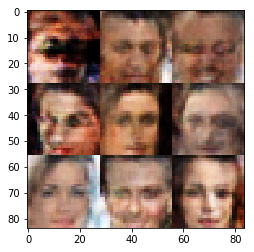

Epoch 0/1 Batch Step 2510... Discriminator Loss: 0.9806... Generator Loss: 1.5311
Epoch 0/1 Batch Step 2520... Discriminator Loss: 0.7224... Generator Loss: 1.6144
Epoch 0/1 Batch Step 2530... Discriminator Loss: 0.8358... Generator Loss: 1.9434
Epoch 0/1 Batch Step 2540... Discriminator Loss: 0.8680... Generator Loss: 1.1057
Epoch 0/1 Batch Step 2550... Discriminator Loss: 0.8297... Generator Loss: 0.8983
Epoch 0/1 Batch Step 2560... Discriminator Loss: 1.0194... Generator Loss: 1.7491
Epoch 0/1 Batch Step 2570... Discriminator Loss: 0.8852... Generator Loss: 1.7431
Epoch 0/1 Batch Step 2580... Discriminator Loss: 0.8367... Generator Loss: 1.5912
Epoch 0/1 Batch Step 2590... Discriminator Loss: 0.8011... Generator Loss: 2.0332
Epoch 0/1 Batch Step 2600... Discriminator Loss: 0.7372... Generator Loss: 1.4558


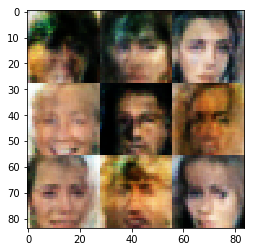

Epoch 0/1 Batch Step 2610... Discriminator Loss: 0.6837... Generator Loss: 1.9721
Epoch 0/1 Batch Step 2620... Discriminator Loss: 0.8363... Generator Loss: 0.8664
Epoch 0/1 Batch Step 2630... Discriminator Loss: 0.7391... Generator Loss: 2.3174
Epoch 0/1 Batch Step 2640... Discriminator Loss: 0.8926... Generator Loss: 0.7236
Epoch 0/1 Batch Step 2650... Discriminator Loss: 0.9029... Generator Loss: 1.9993
Epoch 0/1 Batch Step 2660... Discriminator Loss: 0.6687... Generator Loss: 2.0807
Epoch 0/1 Batch Step 2670... Discriminator Loss: 1.7692... Generator Loss: 0.4158
Epoch 0/1 Batch Step 2680... Discriminator Loss: 0.7929... Generator Loss: 1.1881
Epoch 0/1 Batch Step 2690... Discriminator Loss: 0.6983... Generator Loss: 1.5854
Epoch 0/1 Batch Step 2700... Discriminator Loss: 0.9534... Generator Loss: 1.4855


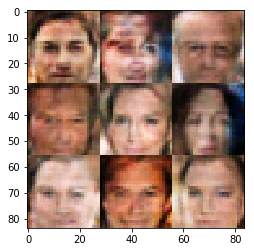

Epoch 0/1 Batch Step 2710... Discriminator Loss: 0.6135... Generator Loss: 1.4837
Epoch 0/1 Batch Step 2720... Discriminator Loss: 0.7148... Generator Loss: 1.6135
Epoch 0/1 Batch Step 2730... Discriminator Loss: 0.9196... Generator Loss: 0.7975
Epoch 0/1 Batch Step 2740... Discriminator Loss: 0.7176... Generator Loss: 1.6632
Epoch 0/1 Batch Step 2750... Discriminator Loss: 0.7416... Generator Loss: 2.6340
Epoch 0/1 Batch Step 2760... Discriminator Loss: 0.6935... Generator Loss: 1.8933
Epoch 0/1 Batch Step 2770... Discriminator Loss: 0.6421... Generator Loss: 1.3438
Epoch 0/1 Batch Step 2780... Discriminator Loss: 0.7138... Generator Loss: 2.3122
Epoch 0/1 Batch Step 2790... Discriminator Loss: 0.7075... Generator Loss: 1.6743
Epoch 0/1 Batch Step 2800... Discriminator Loss: 0.7017... Generator Loss: 2.0549


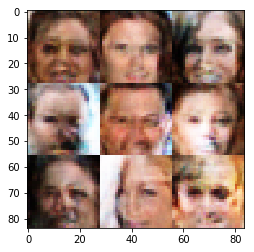

Epoch 0/1 Batch Step 2810... Discriminator Loss: 0.9034... Generator Loss: 0.9018
Epoch 0/1 Batch Step 2820... Discriminator Loss: 0.9419... Generator Loss: 1.8530
Epoch 0/1 Batch Step 2830... Discriminator Loss: 0.7860... Generator Loss: 1.3070
Epoch 0/1 Batch Step 2840... Discriminator Loss: 0.6922... Generator Loss: 1.6847
Epoch 0/1 Batch Step 2850... Discriminator Loss: 1.1939... Generator Loss: 0.6501
Epoch 0/1 Batch Step 2860... Discriminator Loss: 0.8892... Generator Loss: 1.1694
Epoch 0/1 Batch Step 2870... Discriminator Loss: 0.9336... Generator Loss: 2.8626
Epoch 0/1 Batch Step 2880... Discriminator Loss: 1.9927... Generator Loss: 0.4433
Epoch 0/1 Batch Step 2890... Discriminator Loss: 0.9442... Generator Loss: 1.0997
Epoch 0/1 Batch Step 2900... Discriminator Loss: 0.9810... Generator Loss: 1.2364


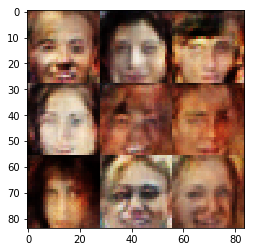

Epoch 0/1 Batch Step 2910... Discriminator Loss: 0.9718... Generator Loss: 3.2744
Epoch 0/1 Batch Step 2920... Discriminator Loss: 1.0428... Generator Loss: 1.2375
Epoch 0/1 Batch Step 2930... Discriminator Loss: 0.6278... Generator Loss: 1.7665
Epoch 0/1 Batch Step 2940... Discriminator Loss: 0.6568... Generator Loss: 2.4422
Epoch 0/1 Batch Step 2950... Discriminator Loss: 1.2156... Generator Loss: 0.8284
Epoch 0/1 Batch Step 2960... Discriminator Loss: 2.3932... Generator Loss: 0.2850
Epoch 0/1 Batch Step 2970... Discriminator Loss: 0.6076... Generator Loss: 1.7543
Epoch 0/1 Batch Step 2980... Discriminator Loss: 1.0389... Generator Loss: 1.0553
Epoch 0/1 Batch Step 2990... Discriminator Loss: 0.8794... Generator Loss: 0.9949
Epoch 0/1 Batch Step 3000... Discriminator Loss: 0.7641... Generator Loss: 1.1724


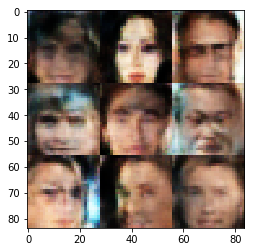

Epoch 0/1 Batch Step 3010... Discriminator Loss: 0.7379... Generator Loss: 1.5593
Epoch 0/1 Batch Step 3020... Discriminator Loss: 0.7921... Generator Loss: 1.8465
Epoch 0/1 Batch Step 3030... Discriminator Loss: 1.1784... Generator Loss: 0.7734
Epoch 0/1 Batch Step 3040... Discriminator Loss: 0.7012... Generator Loss: 2.0425
Epoch 0/1 Batch Step 3050... Discriminator Loss: 0.5391... Generator Loss: 1.8806
Epoch 0/1 Batch Step 3060... Discriminator Loss: 0.8011... Generator Loss: 1.7800
Epoch 0/1 Batch Step 3070... Discriminator Loss: 1.1526... Generator Loss: 1.6279
Epoch 0/1 Batch Step 3080... Discriminator Loss: 0.9382... Generator Loss: 1.3543
Epoch 0/1 Batch Step 3090... Discriminator Loss: 0.8659... Generator Loss: 1.0501
Epoch 0/1 Batch Step 3100... Discriminator Loss: 0.9229... Generator Loss: 1.3446


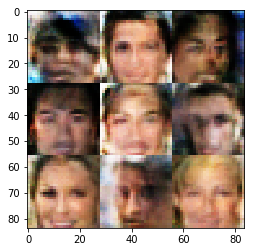

Epoch 0/1 Batch Step 3110... Discriminator Loss: 0.7365... Generator Loss: 1.3388
Epoch 0/1 Batch Step 3120... Discriminator Loss: 1.2790... Generator Loss: 3.4184
Epoch 0/1 Batch Step 3130... Discriminator Loss: 0.7847... Generator Loss: 1.7716
Epoch 0/1 Batch Step 3140... Discriminator Loss: 0.9890... Generator Loss: 1.1428
Epoch 0/1 Batch Step 3150... Discriminator Loss: 0.9360... Generator Loss: 0.7848
Epoch 0/1 Batch Step 3160... Discriminator Loss: 1.3818... Generator Loss: 0.9050
Epoch 0/1 Batch Step 3170... Discriminator Loss: 0.7110... Generator Loss: 1.2341
Epoch 0/1 Batch Step 3180... Discriminator Loss: 0.8037... Generator Loss: 2.5256
Epoch 0/1 Batch Step 3190... Discriminator Loss: 0.6859... Generator Loss: 2.4213
Epoch 0/1 Batch Step 3200... Discriminator Loss: 0.7845... Generator Loss: 1.3560


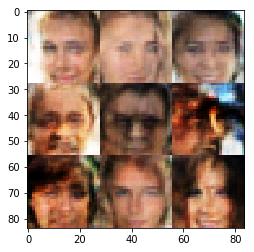

KeyboardInterrupt: 

In [28]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.